<table width=100%><tr>
 <td width=170px> <img src="../images/logo.png" alt="Oxford Logo" height="160" width="160"></td>
 <td style="font-size: 35px; text-align:left"> 
 <table>
  <tr><td style="font-size: 30px; text-align:left"> Surveying Digital Identity: <br>Themes, Trends, and Ontological Foundations</td></tr>
  </table>   
 </td>
 <td width=200>
 <table>
 <tr><td>  Matthew Comb (2910648)</td></tr>
  <tr><td>matthew.comb@linacre.ox.ac.uk</td></tr>
 <tr><td>  Dr Andrew Martin</td></tr>
  <tr><td>andrew.martin@kellogg.ox.ac.uk</td></tr>
  </table>
  </td></tr>
</table>

<table width=100%>
<tr>
<td style="font-size: 15px; text-align:left"> | 2. Patent Modelling</td>
</tr>
</table>

  

# Abstract <a class="anchor" id="research-abstract"></a>

# Table of Contents:

* [Abstract](#research-abstract)
* [Introduction](#introduction)
* [Research Questions](#research-questions)
* [Data Collection](#data-collection)
* [Initialisation](#initialisation)
* [Helper Functions](#helper-functions)
* [Data Loading](#data-loading)
* [Core](#core)
* [Transaction](#transaction)
* [Security](#security)
* [Biometric](#biometric)
* [Blockchain](#blockchain)
* [Identity](#identity)







# Introduction <a class="anchor" id="introduction"></a>

The patent processing pipeline extracts stop-words and creates yearly word files

This Jupyter notebook loads the files, and calculates Term Frequency (TF), Document Frequency (DF) and Term Frequency - Inverse Document Frequency (TF-IDF) metrics as well as baseline statistics and plots them for graphs used in the journal article

# Research Questions <a class="anchor" id="research-questions"></a>

1. Who owns the patents behind present day digital identity technology ?
2. Who is most active in the domain ?
3. Are there any noticeable trends present in the patent dataset ?

# Initialisation <a class="anchor" id="initialisation"></a>

In [1]:
# set parameters
path = r'..//data//Tables//'
li = []
data = []

markers = ['o', 's', '^', 'v', 'D', '*', 'P', 'X', '<', '>', 'H', '|', '_']

In [2]:
graph_names = {}
graph_names["TF-IDF"] = "Term Significance in Patents"
graph_names["DF"] = "Patents with Term"
graph_names["TF"] = "Term Frequency in Patents"

In [3]:
# initialise packages
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.colors as mcolors
import random
import colorsys
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper Functions <a class="anchor" id="helper-functions"></a>

In [4]:
# Marker function
def generate_dark_colors(n):
    """Generate a list of n dark colors."""
    hues = np.linspace(0, 1, n+1)[:-1]  # Evenly spaced hue values
    colors = [colorsys.hsv_to_rgb(h, 1, 0.5) for h in hues]  # Saturation=1, Value=0.5
    return [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b in colors]

# Data Loading <a class="anchor" id="data-loading"></a>

In [5]:
all_files = glob.glob(path + "words_*.txt")
all_files

['..//data//Tables\\words_2010.txt',
 '..//data//Tables\\words_2011.txt',
 '..//data//Tables\\words_2012.txt',
 '..//data//Tables\\words_2013.txt',
 '..//data//Tables\\words_2014.txt',
 '..//data//Tables\\words_2015.txt',
 '..//data//Tables\\words_2016.txt',
 '..//data//Tables\\words_2017.txt',
 '..//data//Tables\\words_2018.txt',
 '..//data//Tables\\words_2019.txt',
 '..//data//Tables\\words_2020.txt',
 '..//data//Tables\\words_2021.txt',
 '..//data//Tables\\words_2022.txt',
 '..//data//Tables\\words_2023.txt']

In [6]:
count_values = {}
print("loading")
for filename in all_files:
        year = int(filename.split("_")[1].split(".")[0])
        if year <= 2010:
            continue
        if year >= 2023:
            continue
        df = pd.read_csv(filename, header=None, names=['word', 'number'], sep=":", skipinitialspace=True)
        
        # Extracting the "_count_" value and assigning it to a variable
        count_value = df[df['word'] == '_COUNT_']['number'].iloc[0]
        count_values[year] = count_value
        print(str(year) + ": " + str(count_value)) 
        
        # Calculate the total number of words for this year
        total_words = df['number'].sum()
        
        # Calculate the ratio metric for each word
        df['ratio'] = df['number'] / count_value
        
        # Add the year column
        df['year'] = year
        
        data.append(df)
print("loaded")

loading
2011: 107
2012: 145
2013: 144
2014: 172
2015: 183
2016: 220
2017: 317
2018: 478
2019: 607
2020: 773
2021: 972
2022: 820
loaded


In [7]:
word_totals = pd.concat(data, ignore_index=True)

In [8]:
# Version with Testing
def plot_graph(selected_words, graph, label, order, ylim):
    # Load the data
    all_files = glob.glob(path + "words_*.txt")

    # Lists to store data
    li = []
    data = []
    word_document_counts = {}
    document_counts = {}  # Dictionary to hold the document count for each year
    data = []
    word_frequencies = []
    document_frequencies = []
    percent_movements = {}
    relative_mae_scores = {}
    relative_mse_scores = {}

    # Process each file
    for filename in all_files:
        year = int(filename.split("_")[1].split(".")[0])
        if year < 2010:
            continue
        if year > 2022:
            continue

        df = pd.read_csv(filename, header=None, names=['type', 'value'], sep=":", skipinitialspace=True)
        df.dropna(inplace=True)

        document_count = df[df['type'] == '_COUNT_']['value'].values[0]

        # Split into word frequency and document frequency data
        word_df = df[df['type'].str.startswith('d_') == False].copy()
        word_df['word'] = word_df['type']
        word_df.drop(columns=['type'], inplace=True)
        word_df.rename(columns={'value': 'term'}, inplace=True)

        # Compute term count
        term_count = word_df['term'].sum()
        word_df['TF'] = word_df['term'] / term_count
        word_df['terms'] = term_count

        d_word_df = df[df['type'].str.startswith('d_')].copy()
        d_word_df['word'] = d_word_df['type'].str.split("d_").str[1]
        d_word_df.drop(columns=['type'], inplace=True)
        d_word_df.rename(columns={'value': 'doc'}, inplace=True)
        d_word_df['docs'] = document_count
        d_word_df['DF'] = d_word_df['doc'] / document_count

        # Merge the two dataframes on 'word'
        merged_df = pd.merge(word_df, d_word_df, on='word', how='outer')

        merged_df['year'] = year
        merged_df['IDF'] = np.log(document_count / merged_df['doc'])
        merged_df['TF-IDF'] = merged_df['TF'] * merged_df['IDF']
        word_frequencies.append(merged_df)
        
    #word_totals = pd.concat(data, ignore_index=True)

    # Combine all the word frequencies into one dataframe
    final_df = pd.concat(word_frequencies, ignore_index=True)

    unique_words = word_totals['word'].unique()
    fig, ax = plt.subplots(figsize=(16, 10))

    i=-1
    
    mse_scores = {}
    mae_scores = {}
    stats_data = {}

    for word in unique_words:
        if word not in selected_words:
            continue
        i = i + 1
        color = colors[i]
        marker = markers[i]    
        subset_data = final_df[final_df['word'] == word].sort_values(by='year')
        
        # Extracting values for 2010 and 2020
        value_2010 = subset_data[subset_data['year'] == 2010][graph].values[0] if 2010 in subset_data['year'].values else None
        value_2020 = subset_data[subset_data['year'] == 2020][graph].values[0] if 2020 in subset_data['year'].values else None

        # Calculating percentage movement
        if value_2010 is not None and value_2020 is not None:
            percent_movement = ((value_2020 - value_2010) / value_2010) * 100
        else:
            percent_movement = None
        percent_movements[word] = percent_movement

        # Predict using Polynomial Regression for the entire set
        x = np.array(subset_data['year']).reshape(-1, 1)
        y = np.array(subset_data[graph])

        poly = PolynomialFeatures(degree=order)
        x_poly = poly.fit_transform(x)

        poly_reg = LinearRegression().fit(x_poly, y)

        # Predict for the original dataset years
        original_predicted = poly_reg.predict(x_poly)

        # Calculate MSE and MAE for predictions on original data
        #mse_scores[word] = mean_squared_error(y, original_predicted)
        #mae_scores[word] = mean_absolute_error(y, original_predicted)
        
        # Calculate MSE and MAE
        mse = mean_squared_error(y, original_predicted)
        mae = mean_absolute_error(y, original_predicted)
        mse_scores[word] = mse
        mae_scores[word] = mae

        # Adjusting errors relative to the mean of the observed responses
        mean_response = np.mean(y)
        relative_mae_scores[word] = mae / mean_response
        relative_mse_scores[word] = np.sqrt(mse) / mean_response
        

        # Calculate basic stats for the series
        stats_data[word] = {
            "max": np.max(y),
            "min": np.min(y),
            "mean": np.mean(y),
            "std": np.std(y)
        }

        future_years = np.arange(subset_data['year'].max() + 1, subset_data['year'].max() + 3).reshape(-1, 1)
        future_years_poly = poly.transform(future_years)
        future_predicted_ratios = poly_reg.predict(future_years_poly)

        # Spline interpolation for the original data
        xnew_original = np.linspace(x.min(), x.max(), 500)
        spl_original = make_interp_spline(x.ravel(), y, k=5)
        ynew_original = spl_original(xnew_original)

        # Combine original dataset years, future years, and their predictions
        combined_years = np.concatenate([x, future_years])
        combined_predicted_ratios = np.concatenate([original_predicted, future_predicted_ratios])

        # Spline interpolation over the combined predicted set (original years + future years)
        xnew_predicted = np.linspace(combined_years.min(), combined_years.max(), 500)
        spl_predicted = make_interp_spline(combined_years.ravel(), combined_predicted_ratios, k=5)
        ynew_predicted = spl_predicted(xnew_predicted)

        # Plot the interpolated original data and the interpolated predictions
        ax.plot(xnew_original, ynew_original, label=word + " (Original Interpolated)", color=color, linestyle='-', marker=marker, markersize=6, markevery=100)
        ax.plot(xnew_predicted, ynew_predicted, label=word + " (Predicted Interpolated)", color=color, linestyle='--', marker=marker, markersize=6, markevery=100)


    # After the loop ends, you can print or analyze the MSE, MAE, and stats
    
    sta = {}
    
    # Calculate the words
    for word, mse in mse_scores.items():
        #print("1:" + word)
        sta[word] = {}
        sta[word]['mse'] = mse
        sta[word]['relmse'] = relative_mse_scores[word]

    for word, mae in mae_scores.items():
        #print("2:" + word)
        sta[word]['mae'] = mae
        sta[word]['relmae'] = relative_mae_scores[word]

    for word, stats in stats_data.items():
        #print("3:" + word)
        sta[word]['max'] = stats["max"]
        sta[word]['min'] = stats["min"]
        sta[word]['mean'] = stats["mean"]
        sta[word]['std'] = stats["std"]

    for word, movement in percent_movements.items():
        if movement is not None:
            sta[word]['move'] = f'{movement:.2f}'
            print(f'Percent movement for {word} from 2010 to 2020: {movement:.2f}%')
        else:
            sta[word]['move'] = ''
            print(f'Percent movement for {word} from 2010 to 2020: Data unavailable')

    # Calculate the words
    for word, mse in mse_scores.items():
        print (f'---Statistics for {word}-------------')
        wmse = sta[word]['mse']
        print(f'MSE: {wmse}')
        wrelmse = sta[word]['relmse']
        print(f'Relative MSE: {wrelmse}')  
        wmae = sta[word]['mae']
        print(f'MAE: {wmae}')
        wrelmae = sta[word]['relmae']
        print(f'Relative MAE: {wrelmae}')
        wmax =sta[word]['max']
        wmin =sta[word]['min']
        wmean =sta[word]['mean']
        wstd =sta[word]['std']
        print(f'Stats: Max={wmax}, Min={wmin}, Mean={wmean}, Std={wstd}')
        wmove = sta[word]['move']
        print(f'Percent movement for {word} from 2010 to 2020: {wmove}%')
        
    ax.set_xlabel('Year')
    ax.set_ylabel(graph)
    ax.set_title(label + ' ' + graph_names[graph] + ' (' + graph + ') Over Time with Polynomial Prediction (order =' + str(order) +')')
    if ylim < 0:
        ax.set_ylim(ylim)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xticks(np.arange(word_totals['year'].min(), future_years.max() + 1, 1))
    plt.axvline(x = 2022, color = 'grey', label = 'prediction line',linestyle='--')
    plt.show()

# Core <a class="anchor" id="core"></a>

Percent movement for user from 2010 to 2020: 40.83%
Percent movement for system from 2010 to 2020: -26.56%
Percent movement for device from 2010 to 2020: 54.53%
Percent movement for information from 2010 to 2020: 54.28%
Percent movement for data from 2010 to 2020: 109.29%
---Statistics for user-------------
MSE: 3.599187976316928e-06
Relative MSE: 0.0705094696251758
MAE: 0.0015719193851688388
Relative MAE: 0.05842186986795444
Stats: Max=0.030326537590289353, Min=0.02031598776119078, Mean=0.026906351828890503, Std=0.0026062600520825293
Percent movement for user from 2010 to 2020: 40.83%
---Statistics for system-------------
MSE: 2.295074819793621e-06
Relative MSE: 0.05969900633589329
MAE: 0.0012453135807276388
Relative MAE: 0.049073541708037745
Stats: Max=0.029240456044604304, Min=0.021411895553038896, Mean=0.025376476557094903, Std=0.002260335359427332
Percent movement for system from 2010 to 2020: -26.56%
---Statistics for device-------------
MSE: 7.452222792703641e-06
Relative MSE: 0

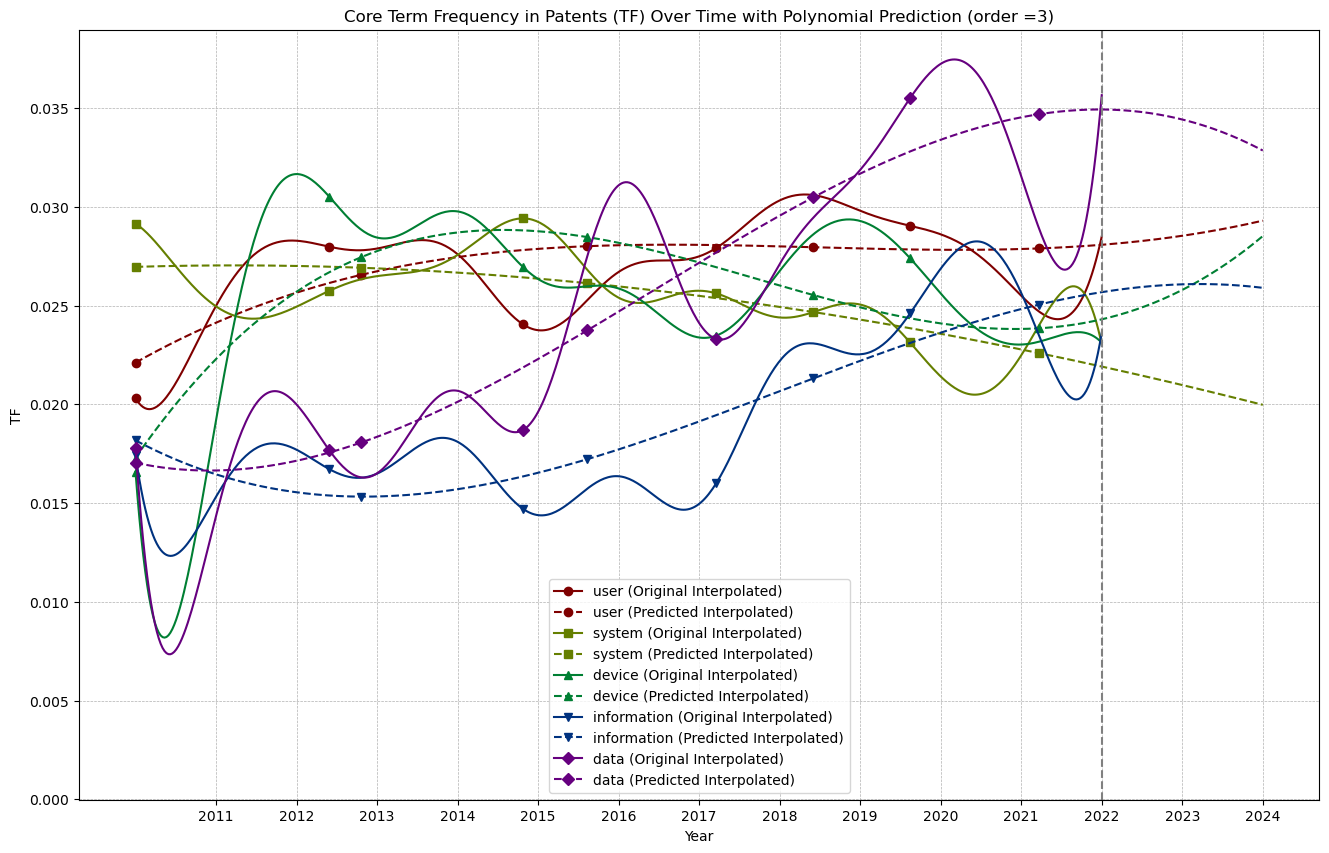

In [17]:
#Core
selected_words = {'user','data','information','device','system'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF','Core',3, -0.00002)

Percent movement for user from 2010 to 2020: 1.31%
Percent movement for system from 2010 to 2020: 27.10%
Percent movement for device from 2010 to 2020: 26.25%
Percent movement for information from 2010 to 2020: 27.25%
Percent movement for data from 2010 to 2020: 29.96%
---Statistics for user-------------
MSE: 0.00016961875606196747
Relative MSE: 0.013850432818426281
MAE: 0.011040677802701623
Relative MAE: 0.011741461118582777
Stats: Max=0.9655172413793104, Min=0.9136363636363637, Mean=0.9403154932079066, Std=0.015418377157656274
Percent movement for user from 2010 to 2020: 1.31%
---Statistics for system-------------
MSE: 0.0008522016506362859
Relative MSE: 0.029868051485108914
MAE: 0.022645714150161665
Relative MAE: 0.023169770219053087
Stats: Max=1.0, Min=0.7816901408450704, Mean=0.9773819047864153, Std=0.056871689205837135
Percent movement for system from 2010 to 2020: 27.10%
---Statistics for device-------------
MSE: 0.0006980934693009854
Relative MSE: 0.027313928534755238
MAE: 0.02

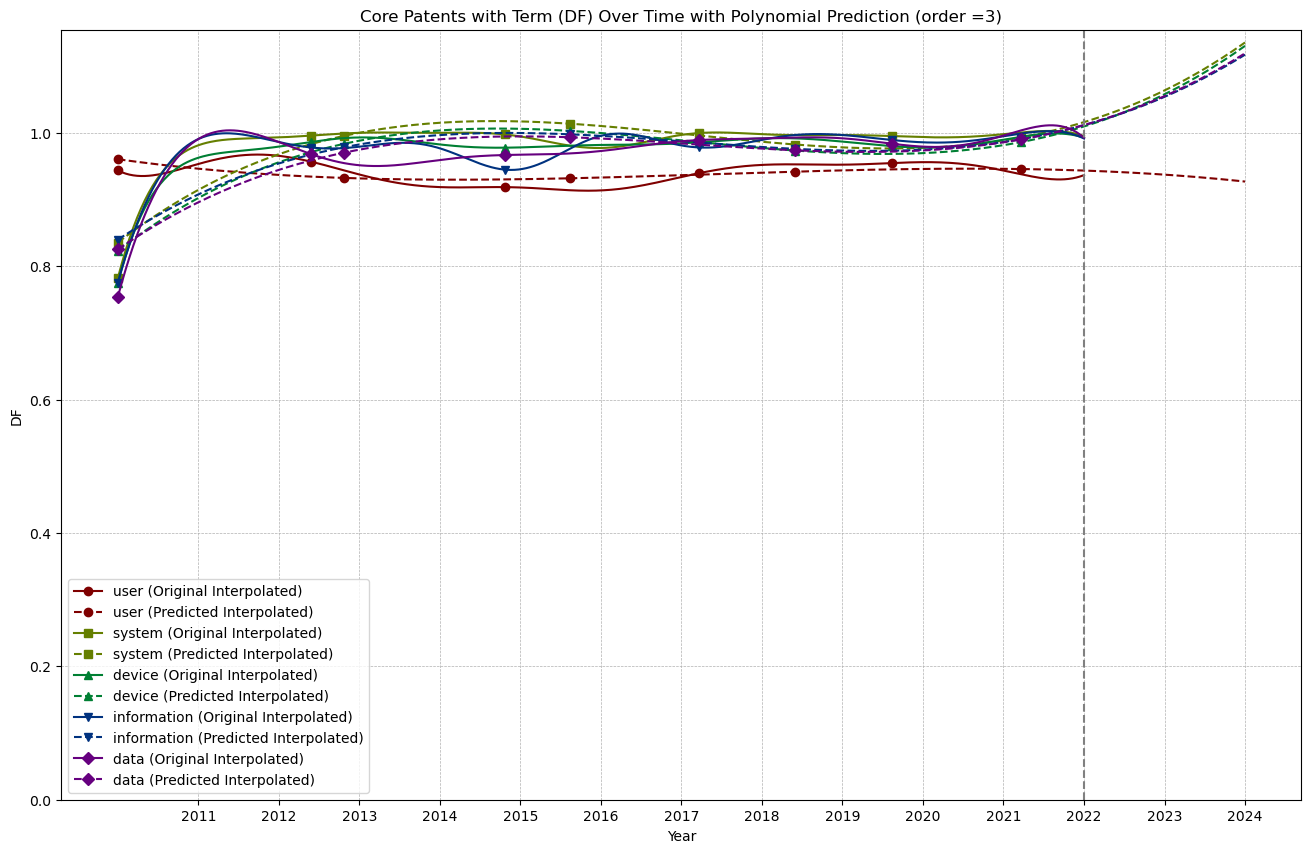

In [18]:
#Core
selected_words = {'user','data','information','device','system'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'DF','Core',3, -0.00002)

Percent movement for user from 2010 to 2020: 9.24%
Percent movement for system from 2010 to 2020: -98.07%
Percent movement for device from 2010 to 2020: -86.54%
Percent movement for information from 2010 to 2020: -91.34%
Percent movement for data from 2010 to 2020: -84.53%
---Statistics for user-------------
MSE: 9.223587466061292e-08
Relative MSE: 0.1842138911878098
MAE: 0.00024131604983675486
Relative MAE: 0.1463722162878982
Stats: Max=0.002412106967657926, Min=0.0009926084210423309, Mean=0.001648646552991399, Std=0.000430788921688394
Percent movement for user from 2010 to 2020: 9.24%
---Statistics for system-------------
MSE: 9.558527896538525e-07
Relative MSE: 1.3994991604506934
MAE: 0.0007556342809656465
Relative MAE: 1.0816550660261317
Stats: Max=0.007180875906741471, Min=0.0, Mean=0.0006985908028349133, Std=0.0018788108221400456
Percent movement for system from 2010 to 2020: -98.07%
---Statistics for device-------------
MSE: 2.4583023588637464e-07
Relative MSE: 0.688088780632767

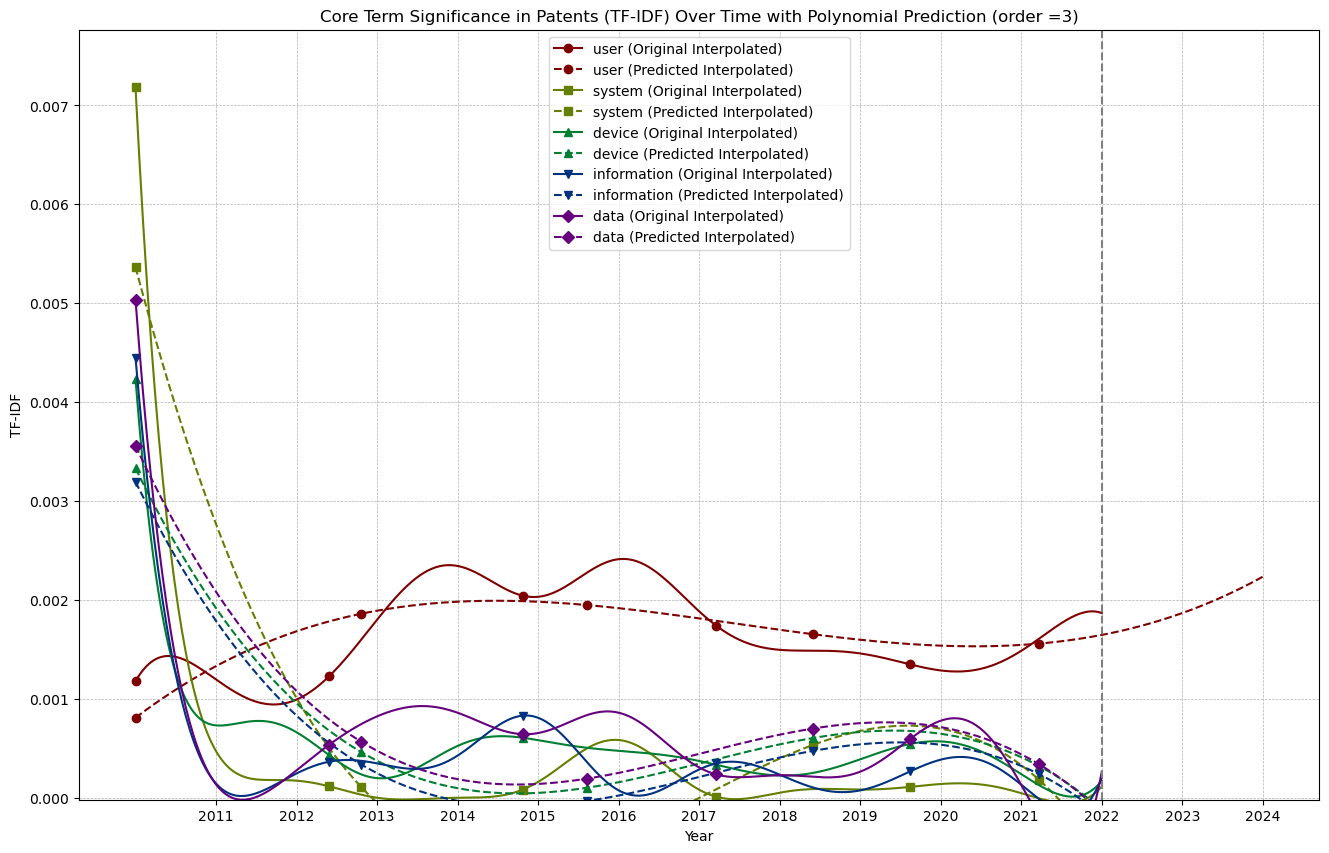

In [483]:
#Core
selected_words = {'user','data','information','device','system'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF-IDF','Core',3, -0.00002)

# Transaction <a class="anchor" id="transaction"></a>

Percent movement for transaction from 2010 to 2020: 23.31%
Percent movement for card from 2010 to 2020: -54.84%
Percent movement for payment from 2010 to 2020: -30.58%
Percent movement for wallet from 2010 to 2020: 351.85%
---Statistics for transaction-------------
MSE: 1.5961877896391193e-06
Relative MSE: 0.19525208562590587
MAE: 0.0009943350695695307
Relative MAE: 0.1536690641554252
Stats: Max=0.00996238834038552, Min=0.003128412527740548, Mean=0.00647062617993061, Std=0.0019466143571476564
Percent movement for transaction from 2010 to 2020: 23.31%
---Statistics for card-------------
MSE: 1.0946480922014184e-07
Relative MSE: 0.09602378345192884
MAE: 0.0002731531572350675
Relative MAE: 0.07927710384672883
Stats: Max=0.0054612069122031105, Min=0.0017489097922399391, Mean=0.0034455491432074875, Std=0.0011414996131466322
Percent movement for card from 2010 to 2020: -54.84%
---Statistics for payment-------------
MSE: 4.5220396996218584e-07
Relative MSE: 0.2712747698904076
MAE: 0.000562931

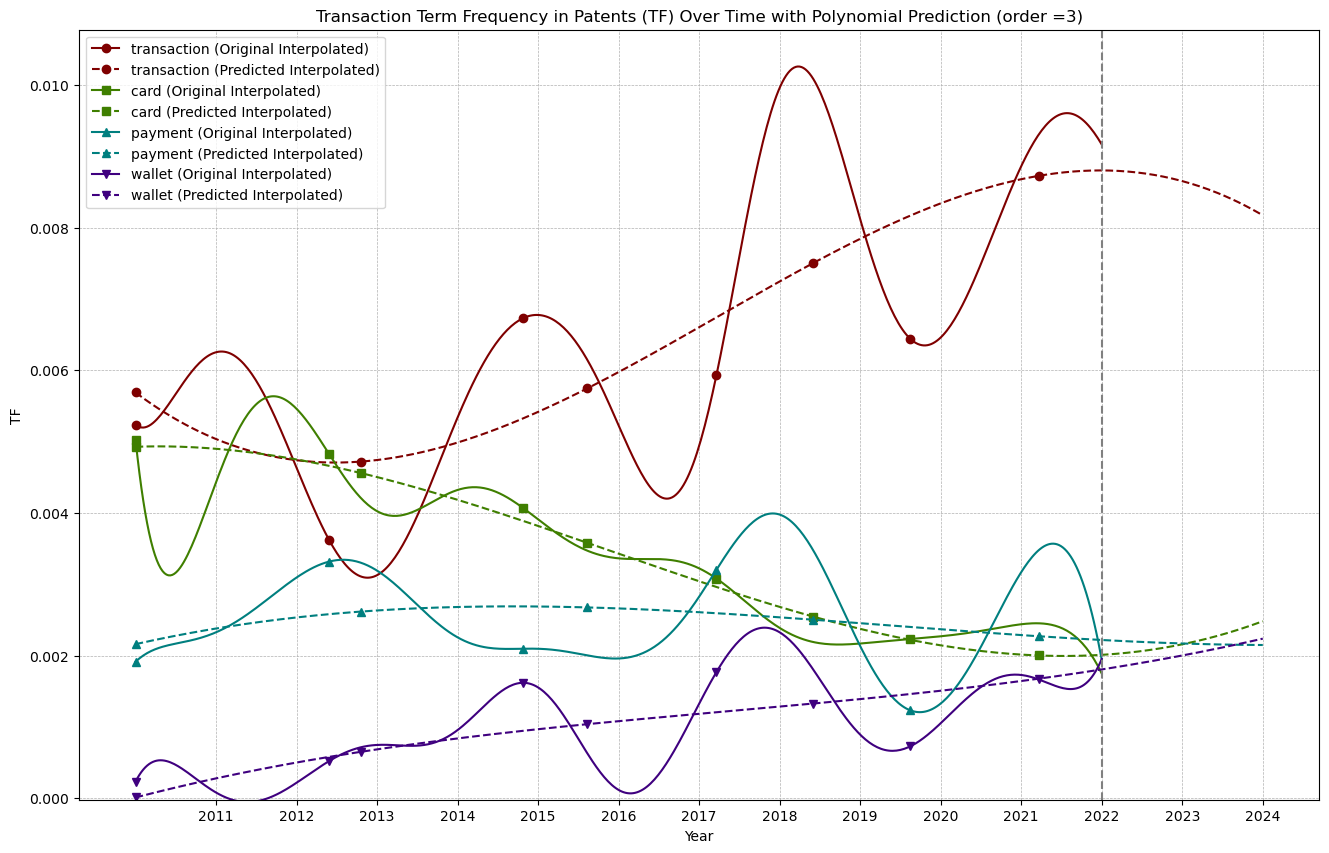

In [9]:
#Transaction
selected_words = {'payment','card', 'transaction','wallet'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF','Transaction', 3, -0.00002)

Percent movement for transaction from 2010 to 2020: 53.08%
Percent movement for card from 2010 to 2020: -28.63%
Percent movement for payment from 2010 to 2020: -2.21%
Percent movement for wallet from 2010 to 2020: 109.94%
---Statistics for transaction-------------
MSE: 0.0025922101072545123
Relative MSE: 0.08444870104039792
MAE: 0.04340098820723284
Relative MAE: 0.07198756640526546
Stats: Max=0.7573221757322176, Min=0.42441860465116277, Mean=0.6028956162082223, Std=0.10834904056537481
Percent movement for transaction from 2010 to 2020: 53.08%
---Statistics for card-------------
MSE: 0.0023828391543804202
Relative MSE: 0.07016907825617603
MAE: 0.040361989549150296
Relative MAE: 0.05801909809229997
Stats: Max=0.8591549295774648, Min=0.5463414634146342, Mean=0.6956673039787731, Std=0.08637852883561317
Percent movement for card from 2010 to 2020: -28.63%
---Statistics for payment-------------
MSE: 0.0013629700183514246
Relative MSE: 0.06925220616456212
MAE: 0.03014328382198841
Relative MAE

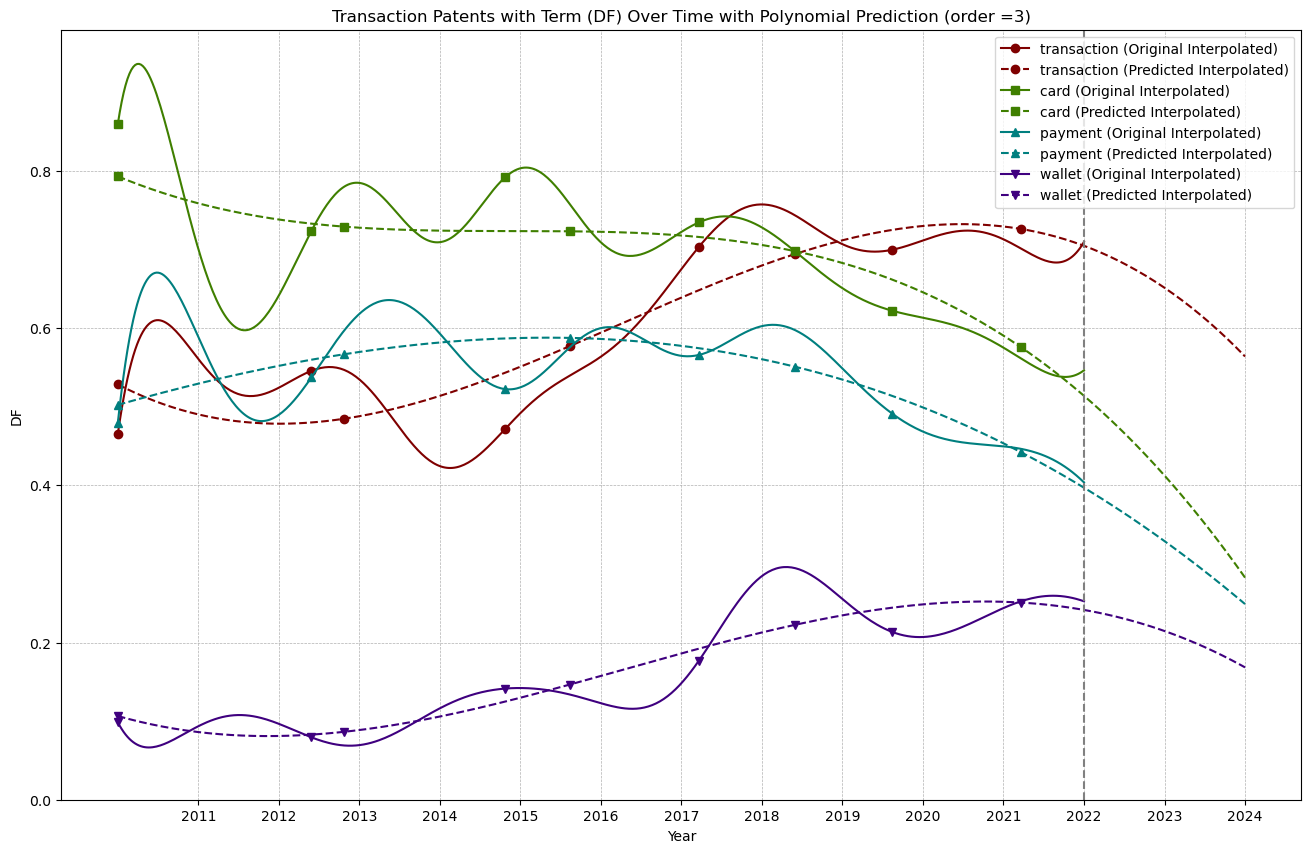

In [23]:
#Transaction
selected_words = {'payment', 'card', 'transaction','wallet'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'DF','Transaction',3, -0.00002)

Percent movement for transaction from 2010 to 2020: -45.22%
Percent movement for card from 2010 to 2020: 45.48%
Percent movement for payment from 2010 to 2020: -28.47%
Percent movement for wallet from 2010 to 2020: 207.20%
---Statistics for transaction-------------
MSE: 6.305463737085664e-07
Relative MSE: 0.2527736797962951
MAE: 0.0005699014030935957
Relative MAE: 0.18141494472744069
Stats: Max=0.004809493738752151, Min=0.0019417936910042343, Mean=0.0031414247814578905, Std=0.000871063060723598
Percent movement for transaction from 2010 to 2020: -45.22%
---Statistics for card-------------
MSE: 1.3608338284323646e-07
Relative MSE: 0.30948541658013834
MAE: 0.00027736469916629143
Relative MAE: 0.23269595155282435
Stats: Max=0.002425509032044819, Min=0.0007582146106061507, Mean=0.0011919618597374987, Std=0.0004317953634644898
Percent movement for card from 2010 to 2020: 45.48%
---Statistics for payment-------------
MSE: 1.731330467204361e-07
Relative MSE: 0.2685753239925204
MAE: 0.00034595

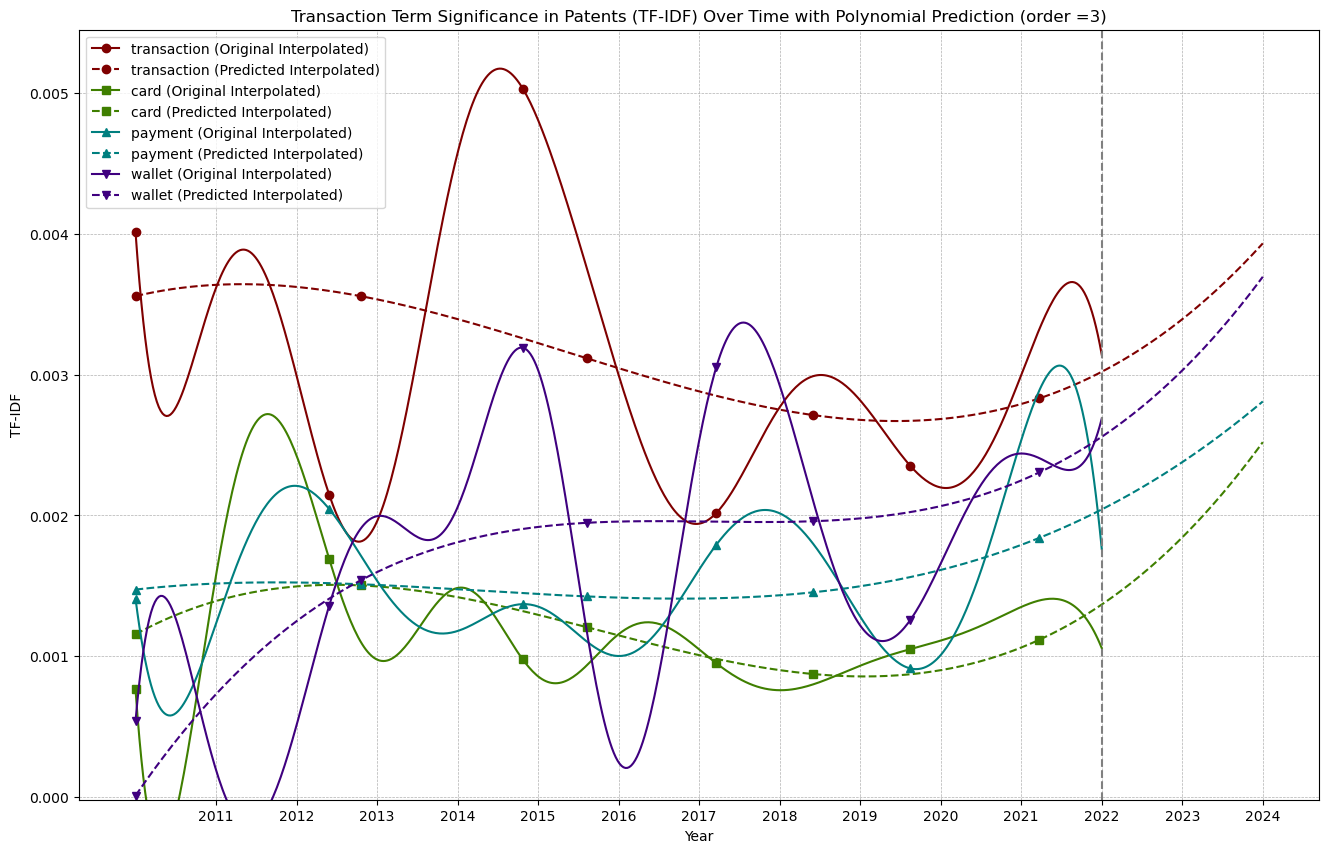

In [24]:
#Transaction
selected_words = {'payment', 'card', 'transaction','wallet'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF-IDF','Transaction',3, -0.00002)

# Security <a class="anchor" id="security"></a>

Percent movement for communication from 2010 to 2020: 5.93%
Percent movement for certificate from 2010 to 2020: 2.93%
Percent movement for storage from 2010 to 2020: 121.55%
Percent movement for encryption from 2010 to 2020: 41.53%
Percent movement for privacy from 2010 to 2020: 154.38%
---Statistics for communication-------------
MSE: 5.745504008490124e-07
Relative MSE: 0.08630735452872726
MAE: 0.0006238193139943715
Relative MAE: 0.07103012119828647
Stats: Max=0.011764339143669958, Min=0.006804093582694701, Mean=0.008782461629946092, Std=0.0013989845578818625
Percent movement for communication from 2010 to 2020: 5.93%
---Statistics for certificate-------------
MSE: 2.504955000095867e-06
Relative MSE: 0.2980286443232112
MAE: 0.0010210002049296798
Relative MAE: 0.19225775746639287
Stats: Max=0.009528530930652687, Min=0.0028986042080084004, Mean=0.005310580017080211, Std=0.0017404421119736786
Percent movement for certificate from 2010 to 2020: 2.93%
---Statistics for storage-------------

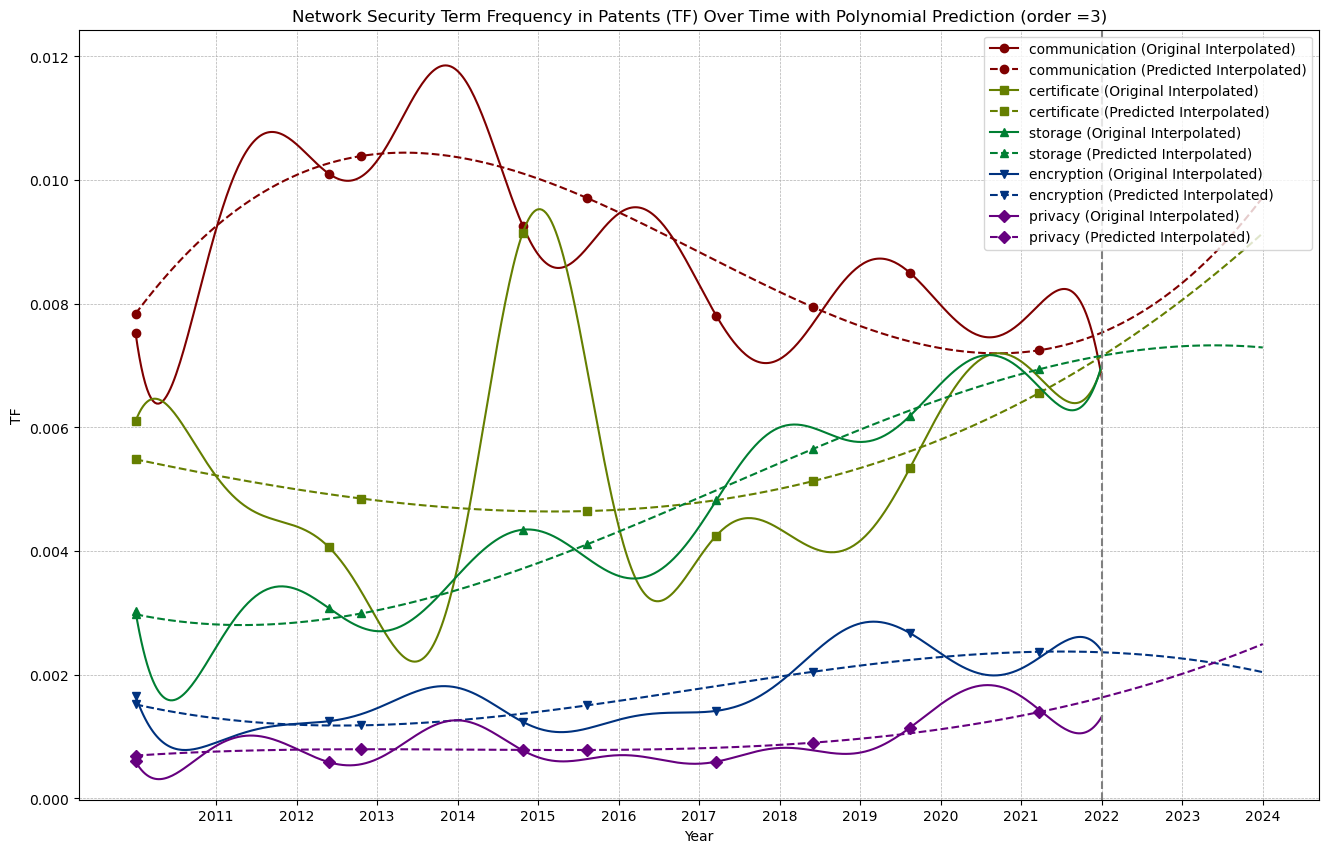

In [494]:
# Security
selected_words = {'certificate','storage','privacy','communication','encryption'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF','Network Security',3, -0.00002)

Percent movement for communication from 2010 to 2020: 30.18%
Percent movement for certificate from 2010 to 2020: 21.38%
Percent movement for storage from 2010 to 2020: 35.46%
Percent movement for encryption from 2010 to 2020: 24.48%
Percent movement for privacy from 2010 to 2020: 47.65%
---Statistics for communication-------------
MSE: 0.0009363709777127902
Relative MSE: 0.03343890464093333
MAE: 0.023866851867407404
Relative MAE: 0.02608093808610515
Stats: Max=0.9636363636363636, Min=0.7323943661971831, Mean=0.9151071095913793, Std=0.057031436256254724
Percent movement for communication from 2010 to 2020: 30.18%
---Statistics for certificate-------------
MSE: 0.0010554645180745235
Relative MSE: 0.05563067372061448
MAE: 0.027414945972935863
Relative MAE: 0.04694397867283173
Stats: Max=0.6752910737386805, Min=0.5069444444444444, Mean=0.5839928090458583, Std=0.05434861704370804
Percent movement for certificate from 2010 to 2020: 21.38%
---Statistics for storage-------------
MSE: 0.0005820

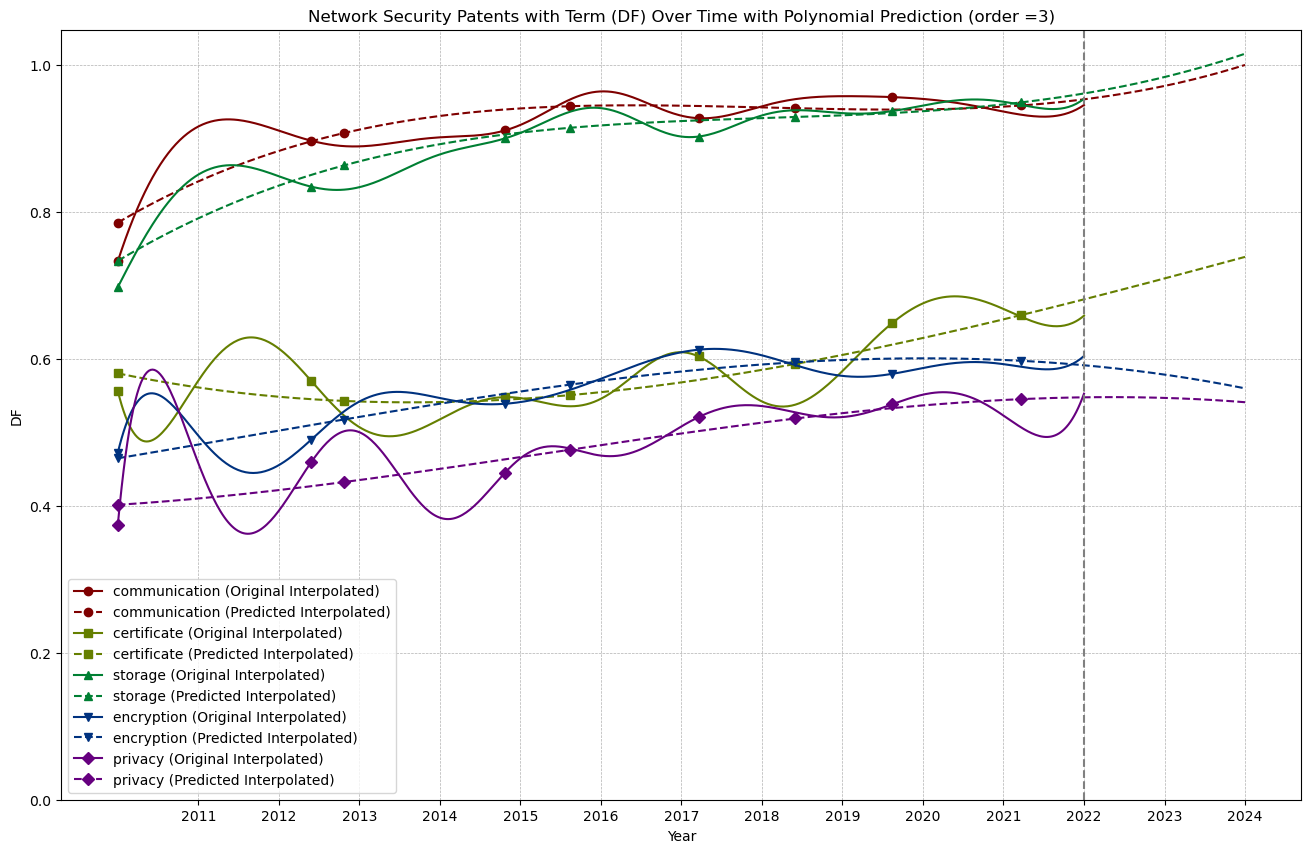

In [495]:
# Security
selected_words = {'certificate','storage','privacy','communication','encryption'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'DF','Network Security',3, -0.00002)

Percent movement for communication from 2010 to 2020: -83.78%
Percent movement for certificate from 2010 to 2020: -31.08%
Percent movement for storage from 2010 to 2020: -64.85%
Percent movement for encryption from 2010 to 2020: 0.28%
Percent movement for privacy from 2010 to 2020: 53.79%
---Statistics for communication-------------
MSE: 8.301700818442195e-08
Relative MSE: 0.36187464801663477
MAE: 0.00021055404343841186
Relative MAE: 0.26444673271648866
Stats: Max=0.0023459699520089567, Min=0.00035035229402669823, Mean=0.0007962058796322708, Std=0.0005397622541487548
Percent movement for communication from 2010 to 2020: -83.78%
---Statistics for certificate-------------
MSE: 8.93210051320224e-07
Relative MSE: 0.33564135125570654
MAE: 0.0005886088430937442
Relative MAE: 0.20903809676199808
Stats: Max=0.005758243382049235, Min=0.001932128787385835, Mean=0.0028157969873018377, Std=0.0009533663285388329
Percent movement for certificate from 2010 to 2020: -31.08%
---Statistics for storage--

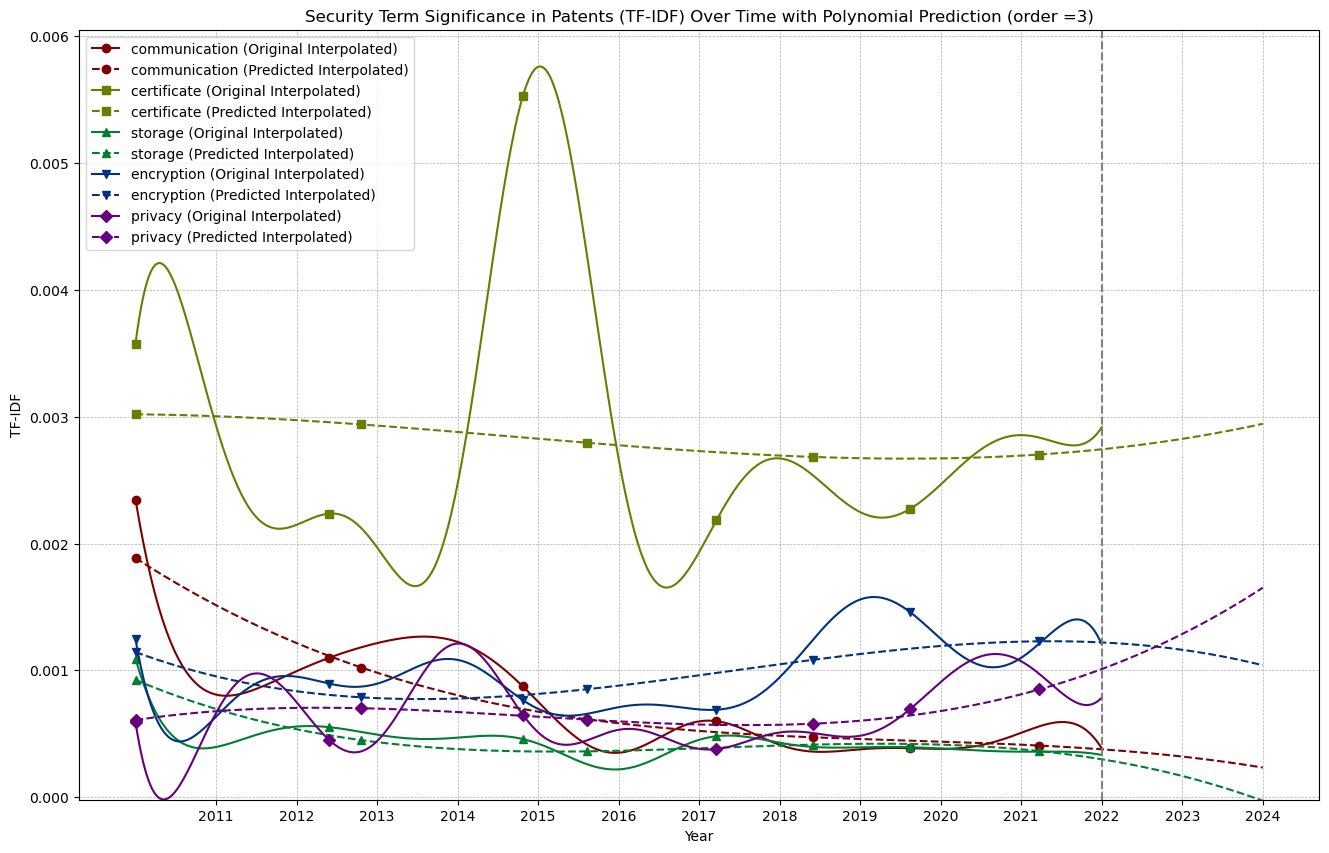

In [496]:
# Security
selected_words = {'certificate','storage','privacy','communication','encryption'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF-IDF','Security',3, -0.00002)

# Biometric <a class="anchor" id="biometric"></a>

Percent movement for fingerprint from 2010 to 2020: -2.69%
Percent movement for hand from 2010 to 2020: -45.11%
Percent movement for voice from 2010 to 2020: 9.32%
Percent movement for face from 2010 to 2020: 49.65%
Percent movement for eye from 2010 to 2020: -64.16%
Percent movement for keystroke from 2010 to 2020: 153.30%
---Statistics for fingerprint-------------
MSE: 7.27468058570739e-08
Relative MSE: 0.35176026885145834
MAE: 6.067874855780119e-11
Relative MAE: 0.26229697504656635
Basic Stats: Max=0.0015063348256895508, Min=0.00039401481880123394, Mean=0.0007667612912240294, Std=0.0002847873288073365
Percent movement for fingerprint from 2010 to 2020: -2.69%
---Statistics for hand-------------
MSE: 2.421374133377421e-09
Relative MSE: 0.1605329816382871
MAE: 6.067874855780119e-11
Relative MAE: 0.12682502795506867
Basic Stats: Max=0.0004311893639956881, Min=0.00021107162688597912, Mean=0.00030652554781760143, Std=7.016736058843058e-05
Percent movement for hand from 2010 to 2020: -45.

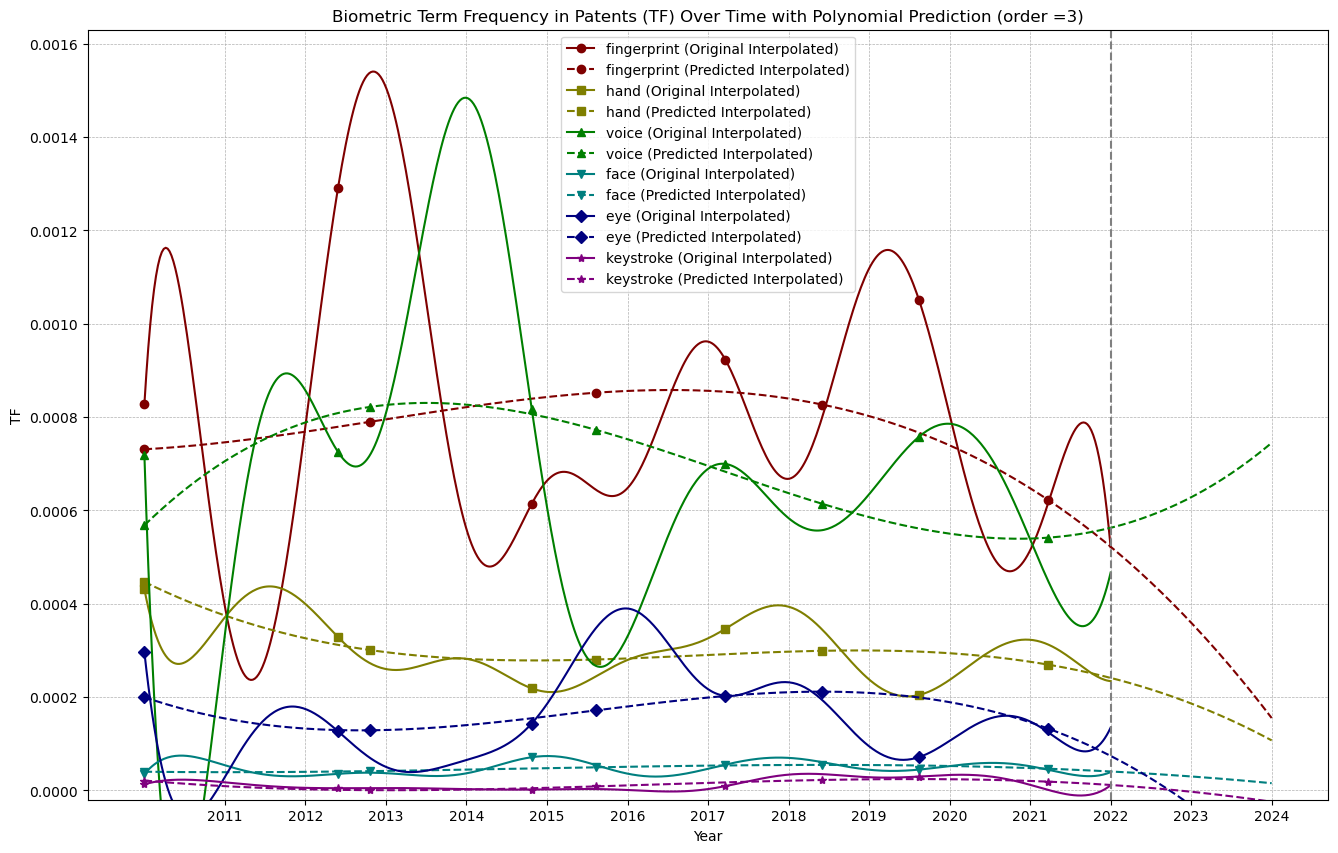

In [461]:
# Biometric
selected_words = {'face','fingerprint','hand','eye','keystroke','voice'}
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF','Biometric',3, -0.00002)

Percent movement for fingerprint from 2010 to 2020: 12.13%
Percent movement for hand from 2010 to 2020: -5.47%
Percent movement for voice from 2010 to 2020: 2.06%
Percent movement for face from 2010 to 2020: 102.07%
Percent movement for eye from 2010 to 2020: 28.59%
Percent movement for keystroke from 2010 to 2020: 37.77%
---Statistics for fingerprint-------------
MSE: 0.0018184963943860524
Relative MSE: 0.11373993381935733
MAE: 0.00012268134606907672
Relative MAE: 0.08498391057838657
Basic Stats: Max=0.4930555555555556, Min=0.2890243902439024, Mean=0.37492400788868824, Std=0.06505324841880934
Percent movement for fingerprint from 2010 to 2020: 12.13%
---Statistics for hand-------------
MSE: 0.0018502416942029788
Relative MSE: 0.1124547294692412
MAE: 0.00012268134606907672
Relative MAE: 0.09556110905683216
Basic Stats: Max=0.48535564853556484, Min=0.31953428201811124, Mean=0.3825044627692363, Std=0.05365153189094574
Percent movement for hand from 2010 to 2020: -5.47%
---Statistics for 

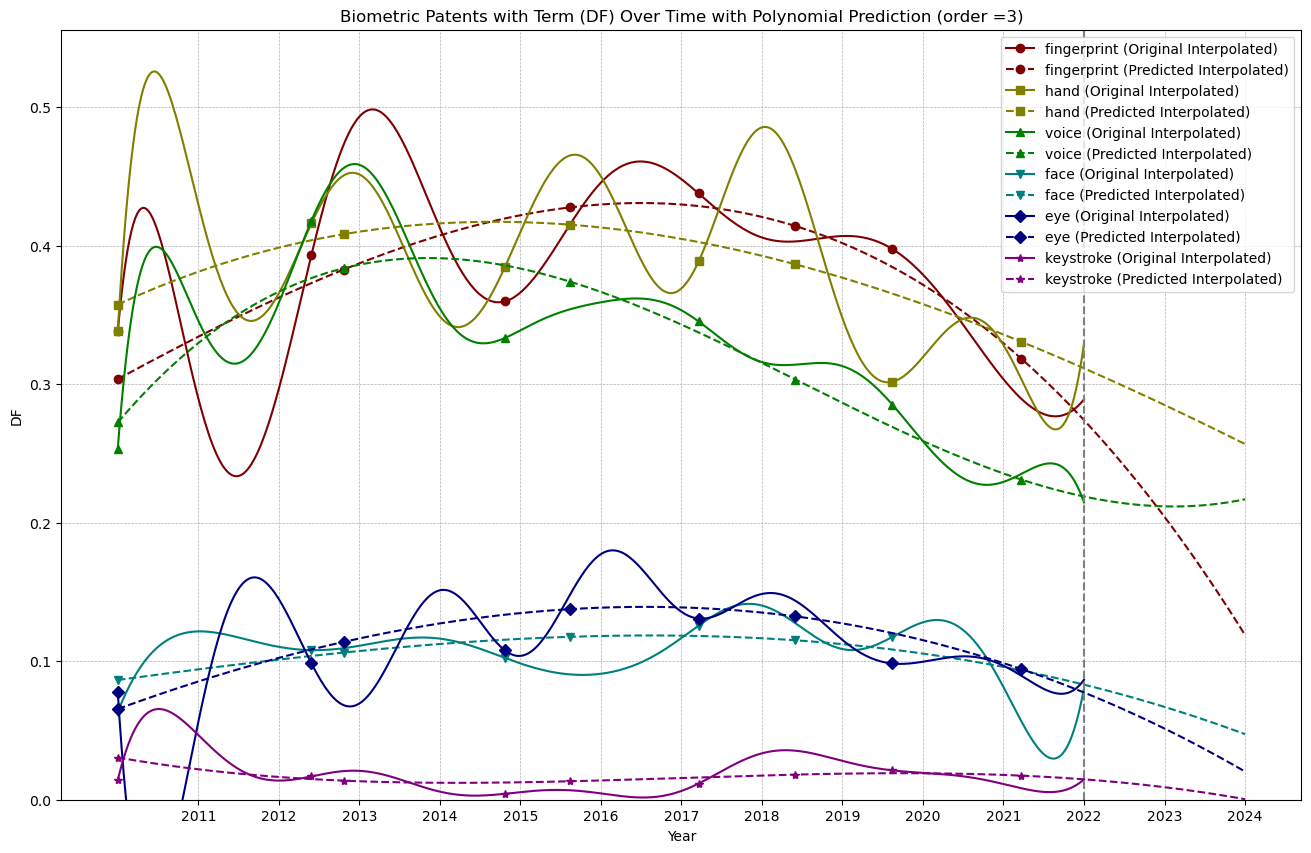

In [462]:
# Biometric
selected_words = {'face','fingerprint','hand','eye','keystroke','voice'}
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'DF','Biometric',3, -0.00002)

Percent movement for fingerprint from 2010 to 2020: -12.97%
Percent movement for hand from 2010 to 2020: -42.26%
Percent movement for voice from 2010 to 2020: 7.70%
Percent movement for face from 2010 to 2020: 11.49%
Percent movement for eye from 2010 to 2020: -67.68%
Percent movement for keystroke from 2010 to 2020: 134.26%
---Statistics for fingerprint-------------
MSE: 3.399240797602469e-08
Relative MSE: 0.25211724202814095
MAE: 6.552137379294866e-10
Relative MAE: 0.20551050672701907
Basic Stats: Max=0.0010651797007730404, Min=0.0004881219603587184, Mean=0.0007312879505895181, Std=0.00018925793559965864
Percent movement for fingerprint from 2010 to 2020: -12.97%
---Statistics for hand-------------
MSE: 2.524910474249364e-09
Relative MSE: 0.16974677515164877
MAE: 6.552137379294866e-10
Relative MAE: 0.14957936430451685
Basic Stats: Max=0.0004676792152468717, Min=0.00018827547733523323, Mean=0.0002960202763104244, Std=7.587421219001094e-05
Percent movement for hand from 2010 to 2020: -

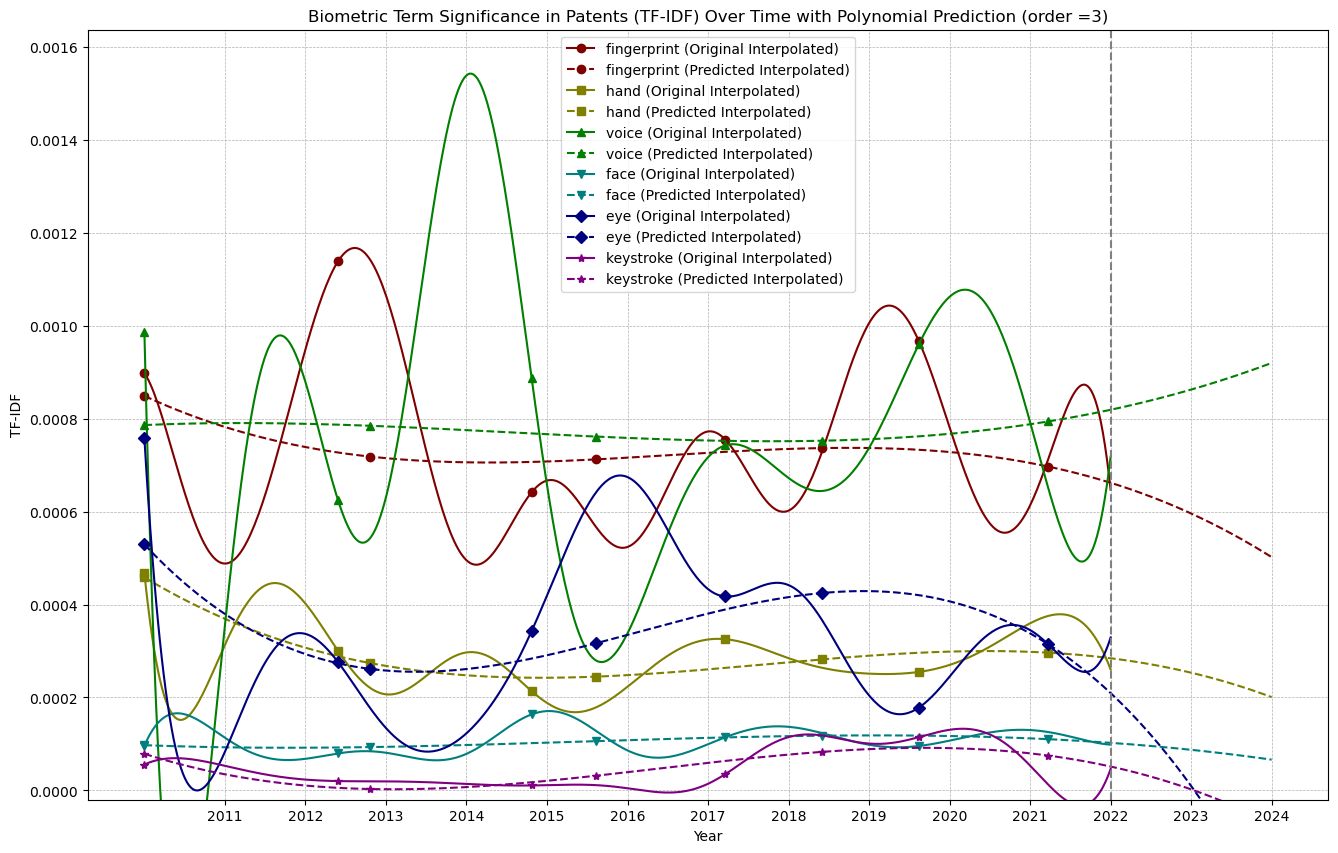

In [463]:
# Biometric
selected_words = {'face','fingerprint','hand','eye','keystroke','voice'}
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF-IDF','Biometric',3, -0.00002)

# Blockchain <a class="anchor" id="blockchain"></a>

Percent movement for credential from 2010 to 2020: 196.24%
Percent movement for block from 2010 to 2020: 381.74%
Percent movement for chain from 2010 to 2020: 1896.20%
Percent movement for ledger from 2010 to 2020: 7720.54%
---Statistics for credential-------------
MSE: 1.4330005068939675e-06
Relative MSE: 0.39753999497533155
MAE: 0.0008364521764054037
Relative MAE: 0.27777859146294787
Stats: Max=0.006188319417677465, Min=0.0007643811452650834, Mean=0.003011219014396132, Std=0.0016185592914218336
Percent movement for credential from 2010 to 2020: 196.24%
---Statistics for block-------------
MSE: 1.1634990255405569e-06
Relative MSE: 0.18700656688448727
MAE: 0.0008445392431247344
Relative MAE: 0.14641773360890895
Stats: Max=0.011674401916240652, Min=0.0012954438432782032, Mean=0.005768011990819038, Std=0.0038178156203333
Percent movement for block from 2010 to 2020: 381.74%
---Statistics for chain-------------
MSE: 5.265335344975195e-07
Relative MSE: 0.20874802400080134
MAE: 0.0006123276

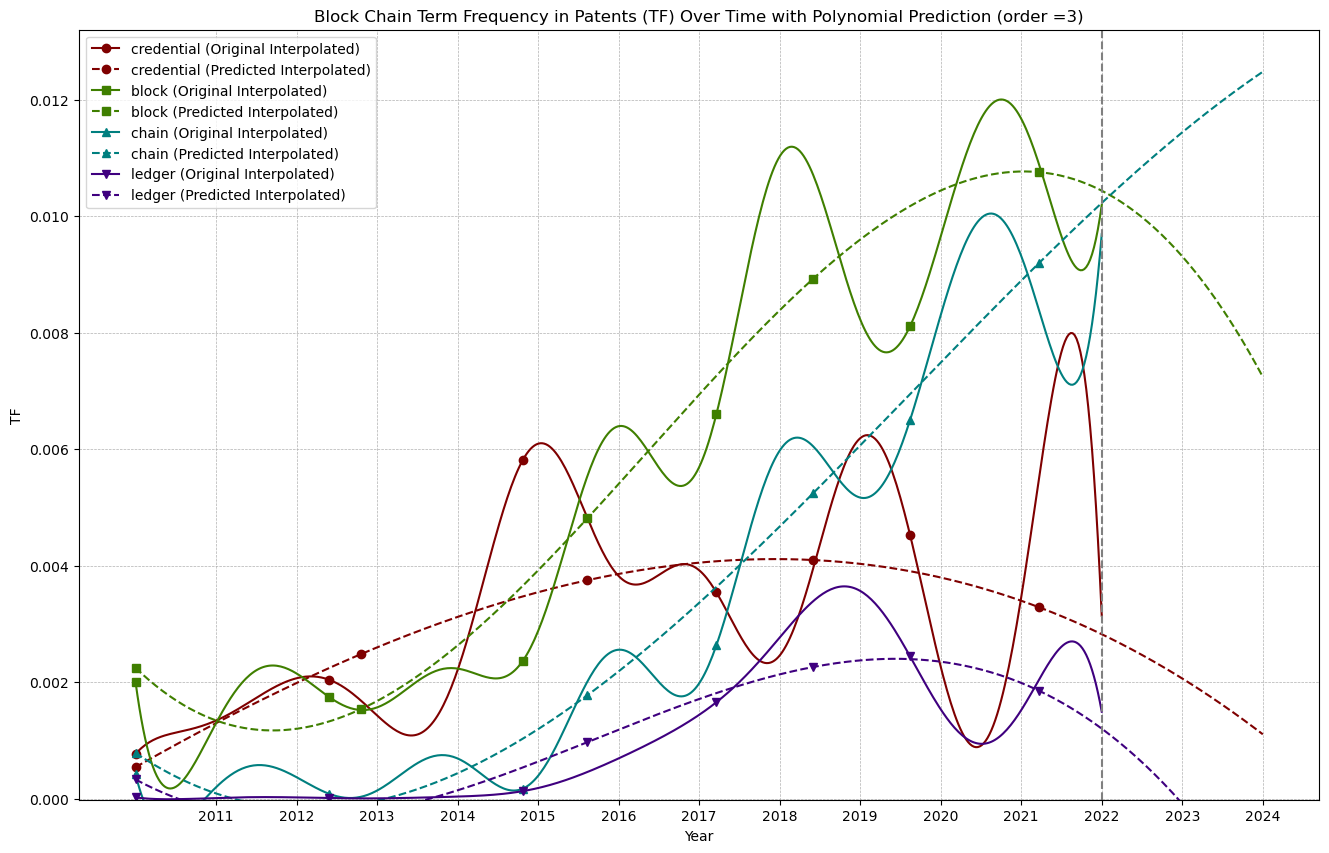

In [497]:
# Blockchain
selected_words = {'block','chain','ledger','credential'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF','Block Chain',3, -0.00002)

Percent movement for credential from 2010 to 2020: 54.61%
Percent movement for block from 2010 to 2020: 47.85%
Percent movement for chain from 2010 to 2020: 228.82%
Percent movement for ledger from 2010 to 2020: 510.80%
---Statistics for credential-------------
MSE: 0.0018113776201429978
Relative MSE: 0.08655047328732943
MAE: 0.034797934468364
Relative MAE: 0.07076498422099255
Stats: Max=0.5818181818181818, Min=0.3380281690140845, Mean=0.4917394506821799, Std=0.06832938620315628
Percent movement for credential from 2010 to 2020: 54.61%
---Statistics for block-------------
MSE: 0.0012184238734164149
Relative MSE: 0.04587503889125386
MAE: 0.028538510971884996
Relative MAE: 0.03750667412184254
Stats: Max=0.8987804878048781, Min=0.5845070422535211, Mean=0.760891538374638, Std=0.10635155255810509
Percent movement for block from 2010 to 2020: 47.85%
---Statistics for chain-------------
MSE: 0.001890236757668925
Relative MSE: 0.09688664713722014
MAE: 0.03440056384026044
Relative MAE: 0.076660

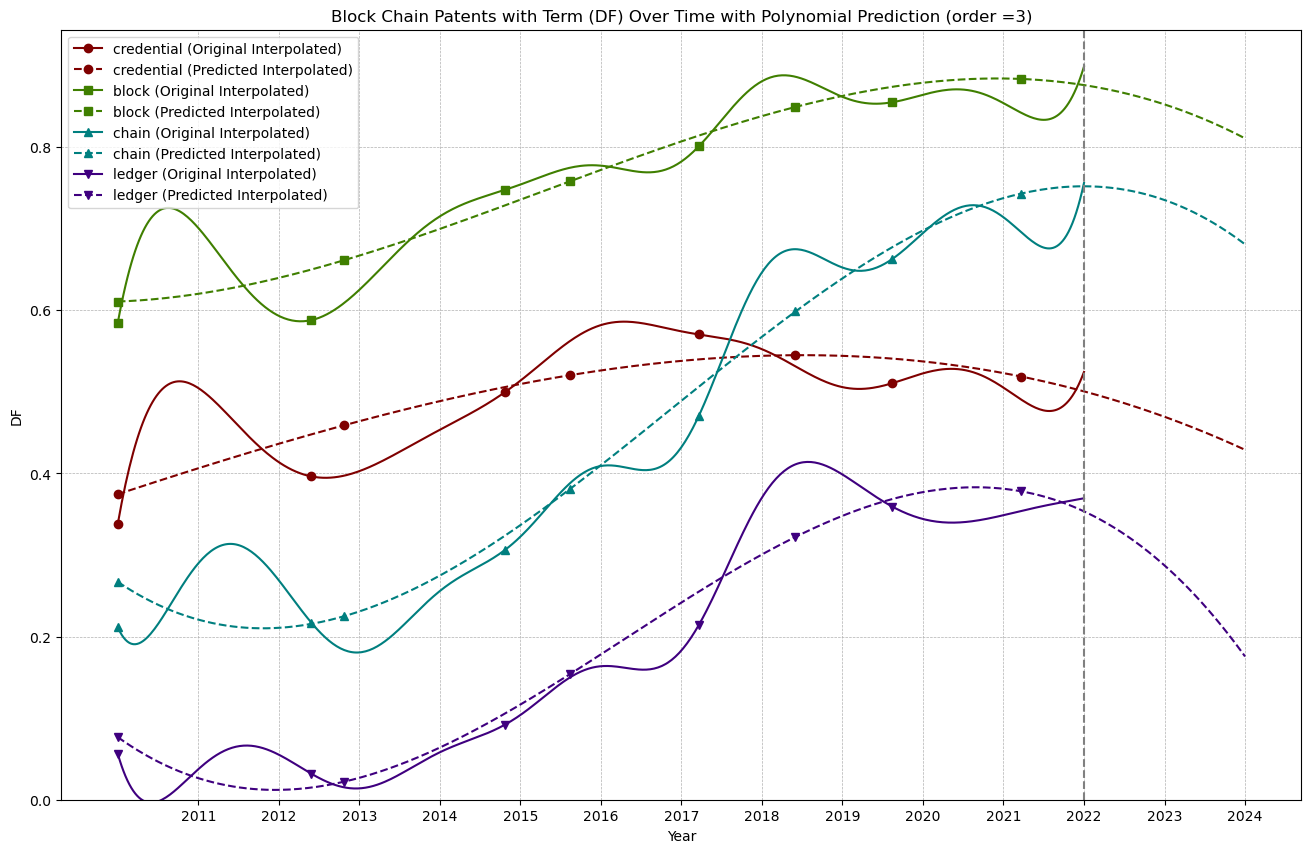

In [498]:
# Blockchain
selected_words = {'block','chain','ledger','credential'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'DF','Block Chain',3, -0.00002)

Percent movement for credential from 2010 to 2020: 77.22%
Percent movement for block from 2010 to 2020: 30.97%
Percent movement for chain from 2010 to 2020: 367.75%
Percent movement for ledger from 2010 to 2020: 2800.45%
---Statistics for credential-------------
MSE: 6.859711778252089e-07
Relative MSE: 0.4070789919863792
MAE: 0.0006212142085918444
Relative MAE: 0.3053283541320893
Stats: Max=0.0042184600379822764, Min=0.000829067699755818, Mean=0.0020345775300092124, Std=0.0010010040489373984
Percent movement for credential from 2010 to 2020: 77.22%
---Statistics for block-------------
MSE: 6.28932539452375e-08
Relative MSE: 0.2183778269905344
MAE: 0.00021287871854088066
Relative MAE: 0.18536970340736927
Stats: Max=0.0018437395049147446, Min=0.00046032394918910124, Mean=0.0011484008153859829, Std=0.00037452616843941354
Percent movement for block from 2010 to 2020: 30.97%
---Statistics for chain-------------
MSE: 1.21659754495816e-07
Relative MSE: 0.21991537084914708
MAE: 0.0002746733572

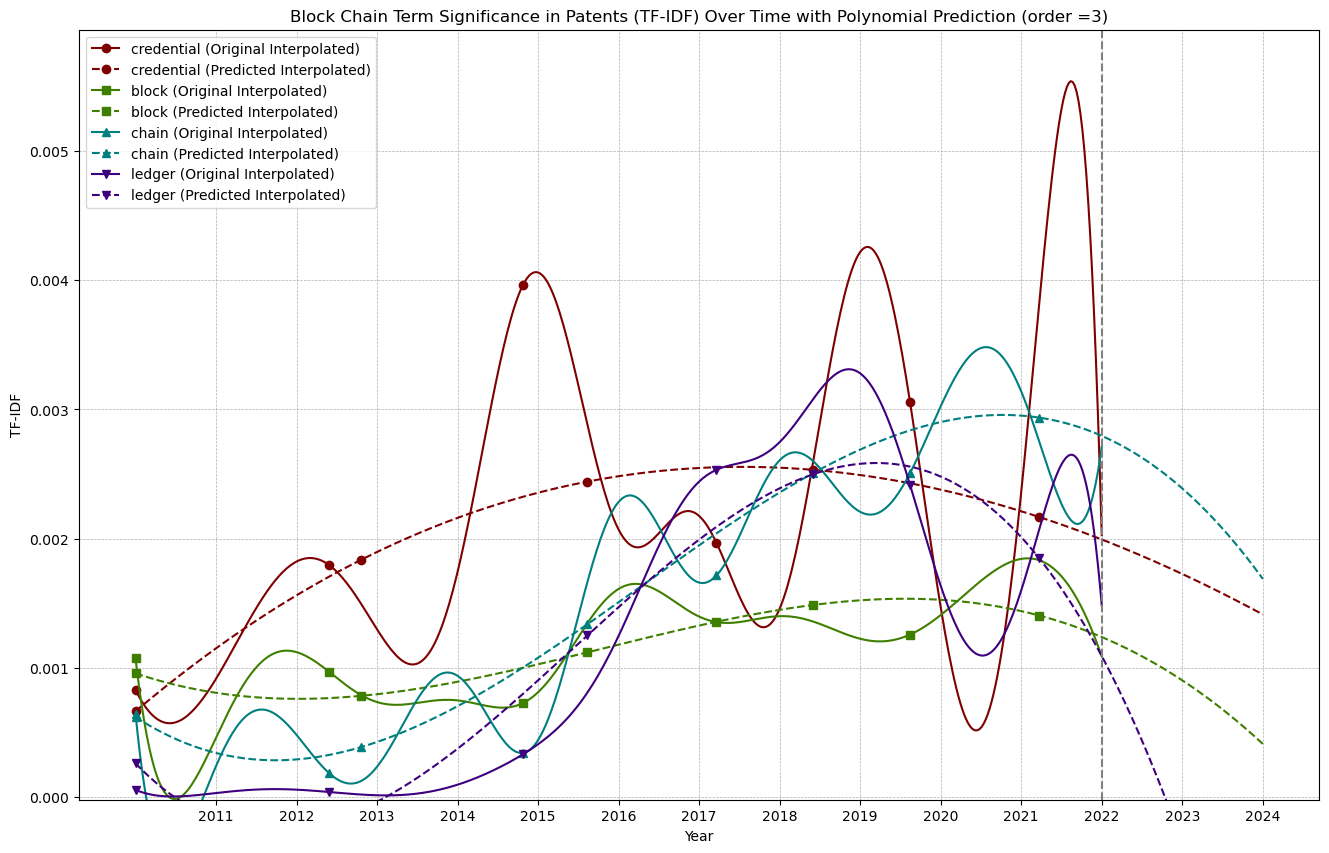

In [499]:
# Blockchain
selected_words = {'block','chain','ledger','credential'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF-IDF','Block Chain',3, -0.00002)

# Identity <a class="anchor" id="identity"></a>

Percent movement for identity from 2010 to 2020: 62.11%
Percent movement for authentication from 2010 to 2020: -4.14%
Percent movement for verification from 2010 to 2020: 109.84%
Percent movement for authorization from 2010 to 2020: 30.44%
---Statistics for identity-------------
MSE: 1.0557114482784563e-06
Relative MSE: 0.06613944117713477
MAE: 0.0007154905312832633
Relative MAE: 0.046056591739127926
Stats: Max=0.021337967046412835, Min=0.010978798924429966, Mean=0.015535029933085774, Std=0.0035934901044775863
Percent movement for identity from 2010 to 2020: 62.11%
---Statistics for authentication-------------
MSE: 3.982071898436909e-07
Relative MSE: 0.06782708057911611
MAE: 0.0004898549486062622
Relative MAE: 0.0526521458505363
Stats: Max=0.011184531379310098, Min=0.008123551588611657, Mean=0.009303608441654286, Std=0.0009506736966845029
Percent movement for authentication from 2010 to 2020: -4.14%
---Statistics for verification-------------
MSE: 2.4161618116876203e-07
Relative MSE: 0

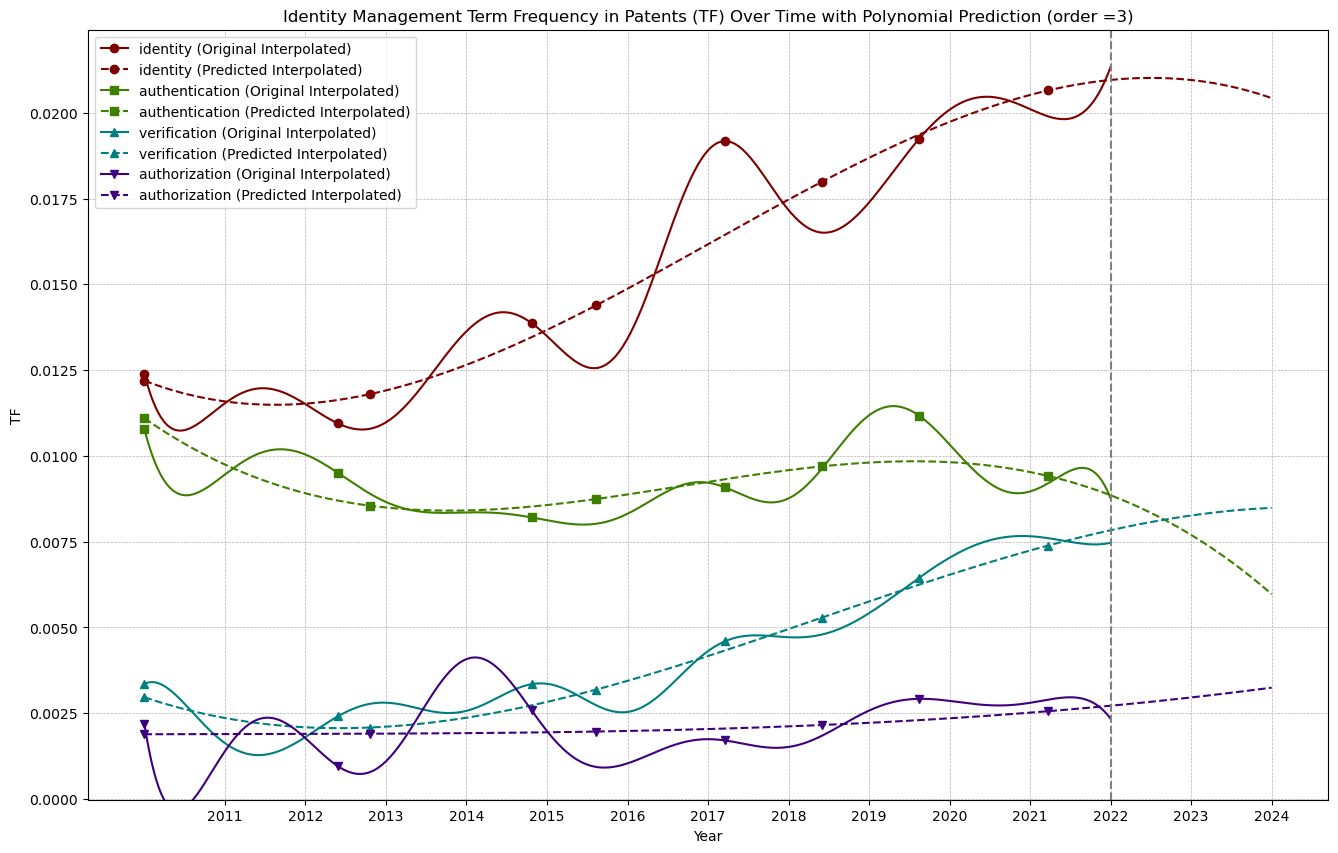

In [19]:
# Identity
selected_words = {'identity','authentication','authorization','verification'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF','Identity Management',3, -0.00002)

Percent movement for identity from 2010 to 2020: 0.45%
Percent movement for authentication from 2010 to 2020: 30.52%
Percent movement for verification from 2010 to 2020: 52.84%
Percent movement for authorization from 2010 to 2020: 31.78%
---Statistics for identity-------------
MSE: 4.562906569746722e-06
Relative MSE: 0.0021414216512975993
MAE: 0.0018430081406906051
Relative MAE: 0.001847602983206591
Stats: Max=1.0, Min=0.9929577464788732, Mean=0.9975130790771882, Std=0.0025809189318290633
Percent movement for identity from 2010 to 2020: 0.45%
---Statistics for authentication-------------
MSE: 0.0009431613379176525
Relative MSE: 0.03707531486179474
MAE: 0.023183495137576927
Relative MAE: 0.02798792901285796
Stats: Max=0.8732212160413971, Min=0.6690140845070423, Mean=0.8283390717093135, Std=0.05040002334992187
Percent movement for authentication from 2010 to 2020: 30.52%
---Statistics for verification-------------
MSE: 0.001474121733555069
Relative MSE: 0.05402339531949815
MAE: 0.0322122

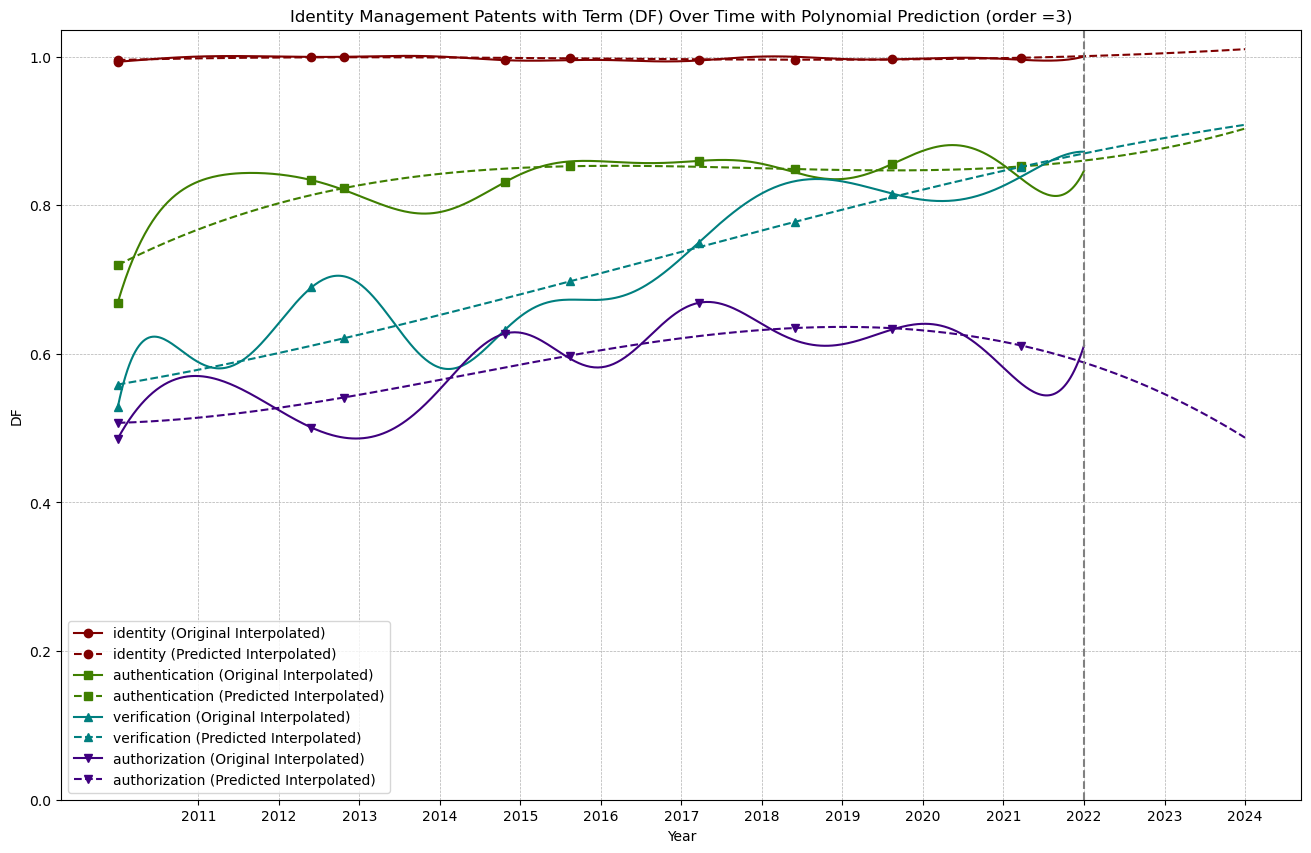

In [20]:
# Identity
selected_words = {'identity','authentication','authorization','verification'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'DF','Identity Management',3, -0.00002)

Percent movement for identity from 2010 to 2020: -40.57%
Percent movement for authentication from 2010 to 2020: -67.67%
Percent movement for verification from 2010 to 2020: -29.61%
Percent movement for authorization from 2010 to 2020: -19.44%
---Statistics for identity-------------
MSE: 1.0477831265508957e-09
Relative MSE: 0.8188675855930502
MAE: 2.592334819177398e-05
Relative MAE: 0.6557964677722675
Stats: Max=0.00011965003314295757, Min=0.0, Mean=3.952956361572863e-05, Std=3.9943759535262586e-05
Percent movement for identity from 2010 to 2020: -40.57%
---Statistics for authentication-------------
MSE: 1.6435219320051536e-07
Relative MSE: 0.22618075033119436
MAE: 0.00031603654337904625
Relative MAE: 0.17632146743581725
Stats: Max=0.004332915910895291, Min=0.0012627583177417907, Mean=0.001792388345985645, Std=0.0007697499047643671
Percent movement for authentication from 2010 to 2020: -67.67%
---Statistics for verification-------------
MSE: 9.209787981285243e-08
Relative MSE: 0.2467666

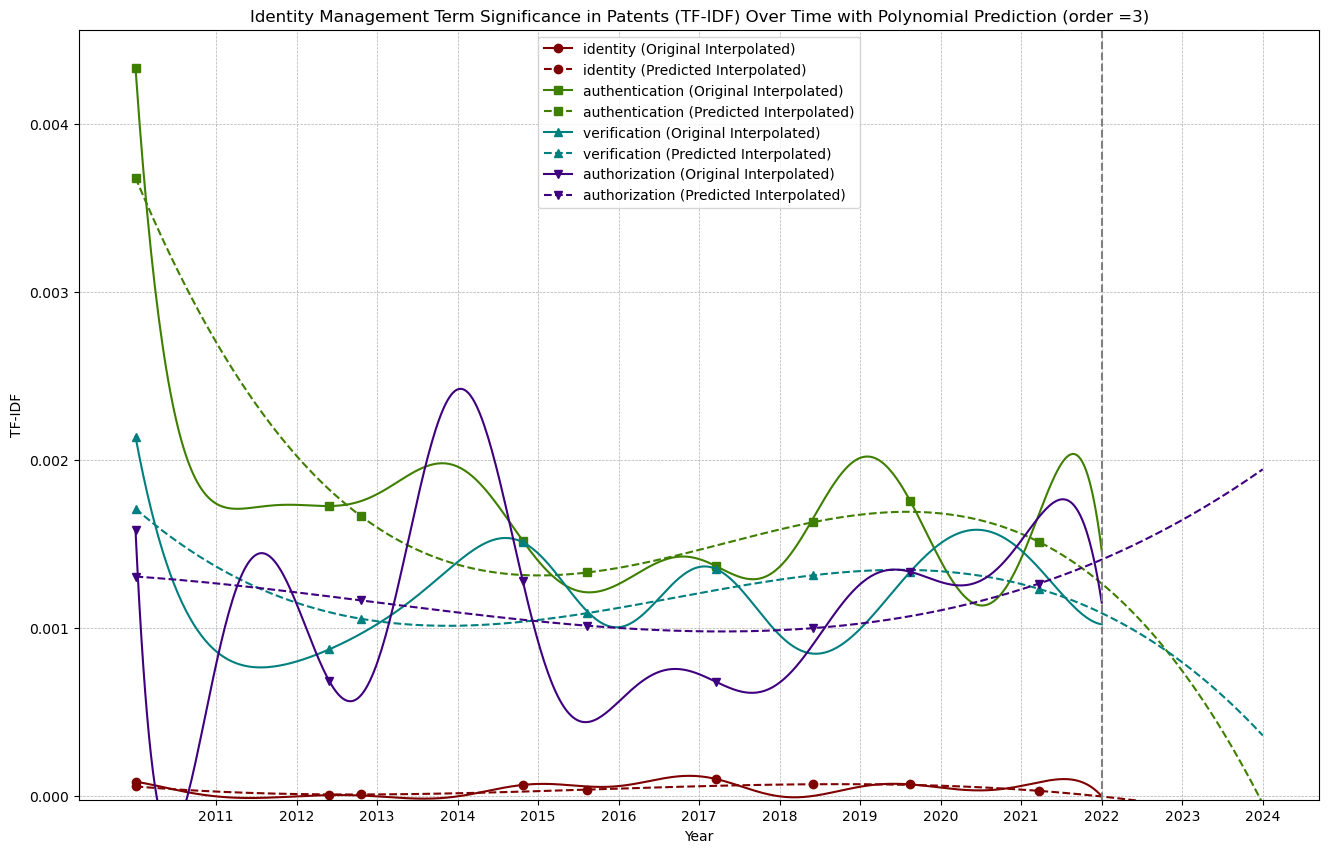

In [21]:
# Identity
selected_words = {'identity','authentication','authorization','verification'}  # Example set of words
colors = generate_dark_colors(len(selected_words))
plot_graph(selected_words, 'TF-IDF','Identity Management',3, -0.00002)

# Scratchpad <a class="anchor" id="scratchpad"></a>

In [ ]:
# Load the data
all_files = glob.glob(path + "words_*.txt")

# Lists to store data
data = []
word_frequencies = []
document_frequencies = []

# Process each file
for filename in all_files:
    year = int(filename.split("_")[1].split(".")[0])
    
    df = pd.read_csv(filename, header=None, names=['type', 'value'], sep=":", skipinitialspace=True)
    df.dropna(inplace=True)
    
    document_count = df[df['type'] == '_COUNT_']['value'].values[0]
    #print(document_count)
    
    # Split into word frequency and document frequency data
    word_df = df[df['type'].str.startswith('d_') == False].copy()
    word_df['word'] = word_df['type']
    word_df.drop(columns=['type'], inplace=True)
    word_df.rename(columns={'value': 'term'}, inplace=True)
    
        # Compute and print term count
    term_count = word_df['term'].sum()
    word_df['TF'] = word_df['term'] / term_count
    word_df['terms'] = term_count
    #print(f"Term count for year {year}: {term_count}")
    
    d_word_df = df[df['type'].str.startswith('d_')].copy()
    d_word_df['word'] = d_word_df['type'].str.split("d_").str[1]
    d_word_df.drop(columns=['type'], inplace=True)
    d_word_df.rename(columns={'value': 'doc'}, inplace=True)
    d_word_df['docs'] = document_count
    d_word_df['DF'] = (d_word_df['doc'] / document_count)
    
    # Merge the two dataframes on 'word'
    merged_df = pd.merge(word_df, d_word_df, on='word', how='outer')

    merged_df['IDF'] = np.log(document_count / merged_df['doc'])
    merged_df['TF-IDF'] = merged_df['TF'] * merged_df['IDF']
    merged_df['year'] = year
    word_frequencies.append(merged_df)

# Combine all the word frequencies into one dataframe
final_df = pd.concat(word_frequencies, ignore_index=True)

filtered_df = final_df[final_df['word'] == 'block']
print(filtered_df)

In [ ]:
# Original Version
def plot_graph(selected_words, graph, label, order, ylim):
    # Load the data
    all_files = glob.glob(path + "words_*.txt")

    # Lists to store data
    li = []
    data = []
    word_document_counts = {}
    document_counts = {}  # Dictionary to hold the document count for each year
    data = []
    word_frequencies = []
    document_frequencies = []

    # Process each file
    for filename in all_files:
        year = int(filename.split("_")[1].split(".")[0])
        if year < 2010:
            continue
        if year > 2022:
            continue

        df = pd.read_csv(filename, header=None, names=['type', 'value'], sep=":", skipinitialspace=True)
        df.dropna(inplace=True)

        document_count = df[df['type'] == '_COUNT_']['value'].values[0]

        # Split into word frequency and document frequency data
        word_df = df[df['type'].str.startswith('d_') == False].copy()
        word_df['word'] = word_df['type']
        word_df.drop(columns=['type'], inplace=True)
        word_df.rename(columns={'value': 'term'}, inplace=True)

        # Compute term count
        term_count = word_df['term'].sum()
        word_df['TF'] = word_df['term'] / term_count
        word_df['terms'] = term_count

        d_word_df = df[df['type'].str.startswith('d_')].copy()
        d_word_df['word'] = d_word_df['type'].str.split("d_").str[1]
        d_word_df.drop(columns=['type'], inplace=True)
        d_word_df.rename(columns={'value': 'doc'}, inplace=True)
        d_word_df['docs'] = document_count
        d_word_df['DF'] = d_word_df['doc'] / document_count

        # Merge the two dataframes on 'word'
        merged_df = pd.merge(word_df, d_word_df, on='word', how='outer')

        merged_df['year'] = year
        merged_df['IDF'] = np.log(document_count / merged_df['doc'])
        merged_df['TF-IDF'] = merged_df['TF'] * merged_df['IDF']
        word_frequencies.append(merged_df)

    # Combine all the word frequencies into one dataframe
    final_df = pd.concat(word_frequencies, ignore_index=True)

    unique_words = word_totals['word'].unique()
    fig, ax = plt.subplots(figsize=(16, 10))

    i=-1
    

    for word in unique_words:
        if word not in selected_words:
            continue
        i = i + 1
        color = colors[i]
        marker = markers[i]    
        subset_data = final_df[final_df['word'] == word].sort_values(by='year')

        # Predict using Polynomial Regression for the entire set
        x = np.array(subset_data['year']).reshape(-1, 1)
        y = np.array(subset_data[graph])

        poly = PolynomialFeatures(degree=order)
        x_poly = poly.fit_transform(x)

        poly_reg = LinearRegression().fit(x_poly, y)

        # Predict for the original dataset years
        original_predicted = poly_reg.predict(x_poly)

        future_years = np.arange(subset_data['year'].max() + 1, subset_data['year'].max() + 3).reshape(-1, 1)
        future_years_poly = poly.transform(future_years)
        future_predicted_ratios = poly_reg.predict(future_years_poly)

        # Spline interpolation for the original data
        xnew_original = np.linspace(x.min(), x.max(), 500)
        spl_original = make_interp_spline(x.ravel(), y, k=5)
        ynew_original = spl_original(xnew_original)

        # Combine original dataset years, future years, and their predictions
        combined_years = np.concatenate([x, future_years])
        combined_predicted_ratios = np.concatenate([original_predicted, future_predicted_ratios])

        # Spline interpolation over the combined predicted set (original years + future years)
        xnew_predicted = np.linspace(combined_years.min(), combined_years.max(), 500)
        spl_predicted = make_interp_spline(combined_years.ravel(), combined_predicted_ratios, k=5)
        ynew_predicted = spl_predicted(xnew_predicted)

        # Plot the interpolated original data and the interpolated predictions
        ax.plot(xnew_original, ynew_original, label=word + " (Original Interpolated)", color=color, linestyle='-', marker=marker, markersize=6, markevery=100)
        ax.plot(xnew_predicted, ynew_predicted, label=word + " (Predicted Interpolated)", color=color, linestyle='--', marker=marker, markersize=6, markevery=100)


    ax.set_xlabel('Year')
    ax.set_ylabel(graph)
    ax.set_title(label + ' ' + graph_names[graph] + ' (' + graph + ') Over Time with Polynomial Prediction (order =' + str(order))
    if ylim < 0:
        ax.set_ylim(ylim)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xticks(np.arange(word_totals['year'].min(), future_years.max() + 1, 1))
    plt.axvline(x = 2022, color = 'grey', label = 'prediction line',linestyle='--')
    plt.show()

loading
2011:
107
2012:
145
2013:
144
2014:
172
2015:
183
2016:
220
2017:
317
2018:
478
2019:
607
2020:
773
2021:
972
2022:
820
loaded


KeyError: 'd_word'

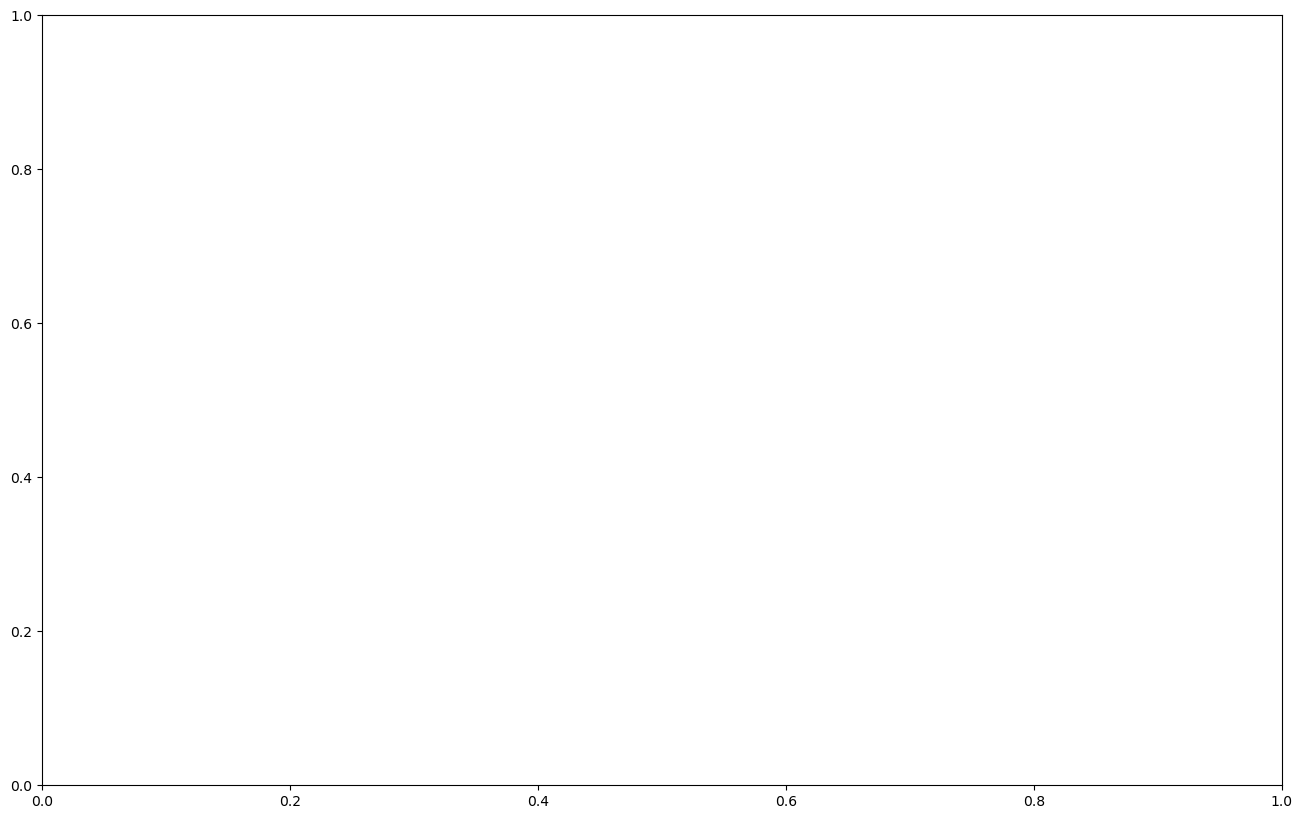

In [8]:
#selected_words = {'network','request','authentication','access''transaction','module','verification','target'}  # Example set of words
#selected_words = {'data','information','user','device','system','identity','method','service'}  # Example set of words
#selected_words = {'certificate','storage','security','privacy','communication','process'}  # Example set of words
#selected_words = {'proof','device','user','identity','block chain','security','transaction','verification','authentication','process'}  # Example set of words
#selected_words = {'device','verification','identity','block','target','information','communication','storage','certificate'}  # Example set of words


# Concatenate all data into a single dataframe




colors = generate_dark_colors(len(selected_words))
unique_words = word_totals['word'].unique()
fig, ax = plt.subplots(figsize=(16, 10))

i=-1
for word in unique_words:
    if word not in selected_words:
        continue
    i = i + 1
    color = colors[i]
    marker = markers[i]
    subset_data = word_totals[word_totals['d_'+'word'] == word].sort_values(by='year')   
    subset_data = word_totals[word_totals['d_'+'word'] == word].sort_values(by='year')
    
    # Predict using Polynomial Regression for the entire set
    x = np.array(subset_data['year']).reshape(-1, 1)
    y = np.array(subset_data['ratio'])
    
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    
    poly_reg = LinearRegression().fit(x_poly, y)
    
    future_years = np.arange(subset_data['year'].max() + 1, subset_data['year'].max() + 6).reshape(-1, 1)
    future_years_poly = poly.transform(future_years)
    predicted_ratios = poly_reg.predict(future_years_poly)
    
    combined_years = np.concatenate([x, future_years])
    combined_ratios = np.concatenate([y, predicted_ratios])
    
    # Spline interpolation over the combined set
    xnew = np.linspace(combined_years.min(), combined_years.max(), 500)
    spl = make_interp_spline(combined_years.ravel(), combined_ratios, k=3)
    ynew = spl(xnew)
    
    # Plot the interpolated curve
    ax.plot(xnew[xnew <= subset_data['year'].max()], ynew[xnew <= subset_data['year'].max()], label=word, color=color, linestyle='-', marker=marker, markersize=6, markevery=100)
    ax.plot(xnew[xnew > subset_data['year'].max()], ynew[xnew > subset_data['year'].max()], color=color, linestyle='--',marker=marker, markersize=6, markevery=100)

ax.set_xlabel('Year')
ax.set_ylabel('Ratio')
ax.set_title('Word Occurrence Ratios Over Time with Predictions')
ax.set_ylim(0)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(np.arange(word_totals['year'].min(), future_years.max() + 1, 1))

plt.show()